In [11]:
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from matplotlib.patches import Path, PathPatch
import pandas as pd
from shapely.geometry import Point, shape, Polygon
from shapely.ops import unary_union, cascaded_union
from geopandas.tools import sjoin
import geopandas as gpd
from netCDF4 import Dataset
from cartopy import crs as ccrs
from cartopy.io.shapereader import Reader
from sklearn.metrics import mean_squared_error
import scipy.stats as st
from sklearn.linear_model import LinearRegression

In [12]:
# functions
def stats_normalized(data,prediction):
    x,y=data[~np.isnan(data)],prediction[~np.isnan(data)] # get rid of NaNs
    mu_d,mu_p = np.mean(x),np.mean(y)
    nmb = np.sum(y-x)/np.sum(x)*100
    nme = np.sum(np.abs(y-x))/np.sum(x)*100
    r,p = st.pearsonr(x,y)
    return mu_d,mu_p,nmb,nme,r,p

In [13]:
# ## Upload vehicle emission datasets
# # FIVE Measures ..
# # NOx = NO + NO2  (Harkins, C., McDonald, B. C., Henze, D. K., & Wiedinmyer, C. (2021). A fuel-based method for updating mobile source emissions during the COVID-19 pandemic. Environmental Research Letters. https://doi.org/10.1088/1748-9326/ac0660)
# # from McDonald, B. C., Goldstein, A. H., & Harley, R. A. (2015). Long-Term Trends in California Mobile Source Emissions and Ambient Concentrations of Black Carbon and Organic Aerosol. Environmental Science & Technology, 49(8), 5178–5188. https://doi.org/10.1021/es505912b
five= gpd.read_file('five_1_33km_cons_annual.shp') #units ton/km$^2$/hour
five_new= five.to_crs('EPSG:4326')

#LADCO setup described here:  https://doi.org/10.1029/2022JD037942
ladco =  gpd.read_file('ladco_1_33km_cons_annual.shp')
ladco_new= ladco.to_crs('EPSG:4326')
                      
# paper currently being written 
rowan = gpd.read_file('uvm_1_33km_cons_annual.shp') #units tons/km2/hour
rowan_new = rowan.to_crs('EPSG:4326')

# NEMO https://www.nature.com/articles/s41597-022-01790-9 
nemo = gpd.read_file('nemo_1_33km_cons_annual.shp') #units tons/km2/hour
nemo_new= nemo.to_crs('EPSG:4326')

#cook county il
cmap_cty = gpd.read_file('C:/Users/x12la/Desktop/Scripts/CMAP_cty.shp')
cmap_cty = cmap_cty.to_crs('EPSG:4326')

In [14]:
#primary roads
primary_roads = gpd.read_file('C:/Users/x12la/Desktop/Scripts/tl_2016_us_primaryroads.shp')
primary_roads = primary_roads.to_crs('EPSG:4326')

In [15]:
# #Clip geopandas files to chicago 
cmap_roads = gpd.clip(primary_roads, cmap_cty.to_crs('EPSG:4326'))
cmap_five = gpd.clip(five_new, cmap_cty.to_crs('EPSG:4326'))
cmap_ladco = gpd.clip(ladco_new, cmap_cty.to_crs('EPSG:4326'))
cmap_rowan = gpd.clip(rowan_new, cmap_cty.to_crs('EPSG:4326'))
cmap_nemo = gpd.clip(nemo_new, cmap_cty.to_crs('EPSG:4326'))

<h1> Plot CMAP NOX Flux

min  0.005250311407603759
max  57.6638472707648
mean  7.0903673817919355
median  3.587677783535835
total 43038.53000747705


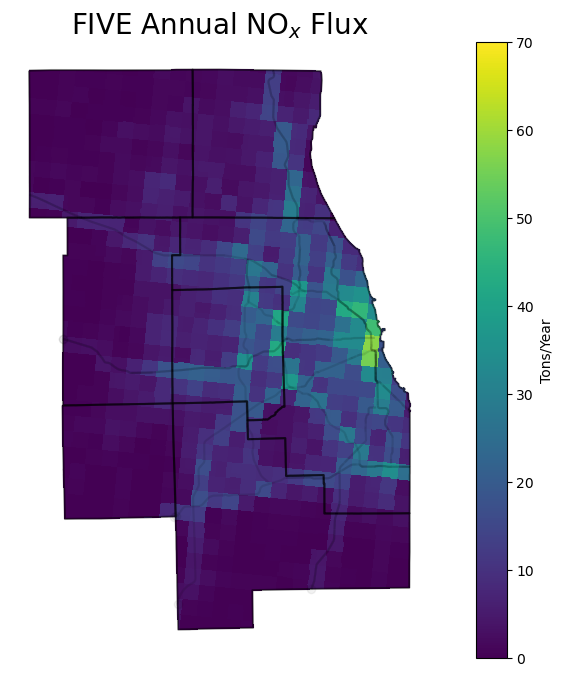

In [16]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_five['NOX_flux'] = cmap_five['NOX']/(1.33)
cmap_five.plot('NOX_flux',ax=ax,vmin=0,vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Tons/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('FIVE Annual NO$_x$ Flux', fontsize=20)
#plt.savefig('FIVE_AnnualNOxYear.png', transparent=True)

print('min ',cmap_five['NOX_flux'].min())
print('max ',cmap_five['NOX_flux'].max())
print('mean ',cmap_five['NOX_flux'].mean())
print('median ',cmap_five['NOX_flux'].median())
print('total',((cmap_five['NOX_flux'].sum())))

min  4.340791113121149e-08
max  78.32416907720281
mean  2.926740456245227
median  1.1819259719680422
total 17765.31456940853


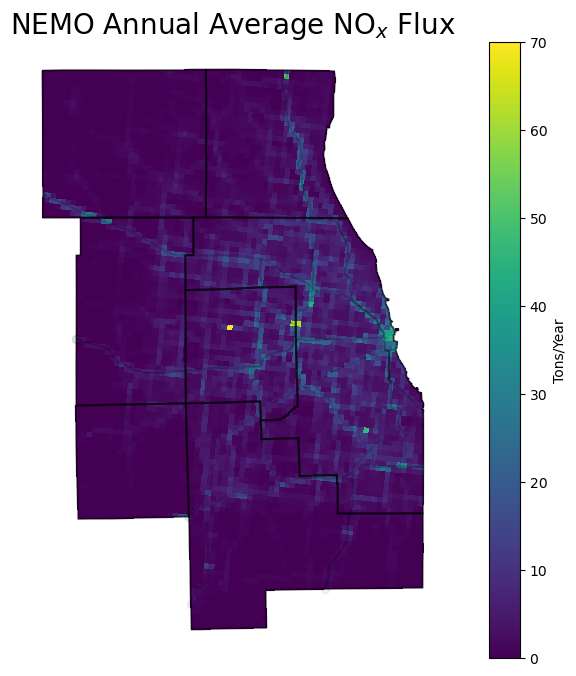

In [17]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_nemo['NOX_flux'] = cmap_nemo['NOX']/(1.33**2)
cmap_nemo.plot('NOX_flux',ax=ax,vmin=0,vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Tons/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('NEMO Annual Average NO$_x$ Flux', fontsize=20)
#plt.savefig('nemo_AnnualNOxYear.png', transparent=True)

print('min ',cmap_nemo['NOX_flux'].min())
print('max ',cmap_nemo['NOX_flux'].max())
print('mean ',cmap_nemo['NOX_flux'].mean())
print('median ',cmap_nemo['NOX_flux'].median())
print('total',((cmap_nemo['NOX_flux'].sum())))

min  0.0
max  136.29914839653614
mean  3.345449703801538
total 20306.879702075334


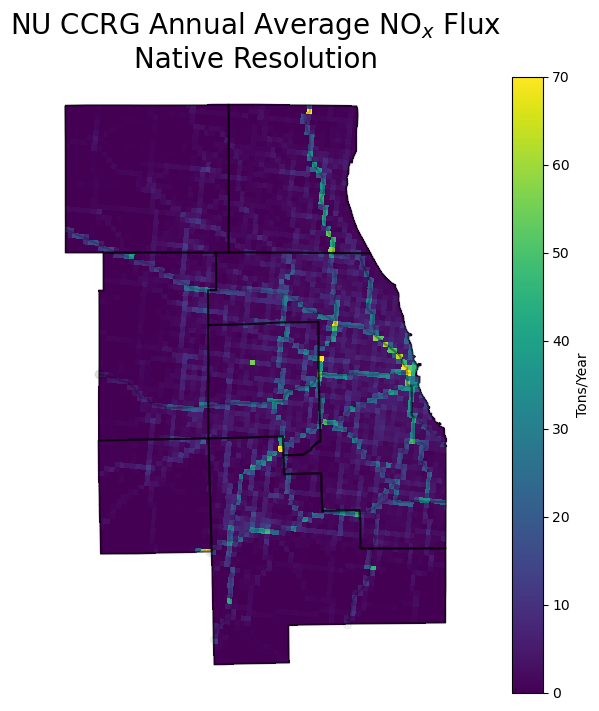

In [18]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco['NOX_flux'] = cmap_ladco['NOX']/(1.33**2)
cmap_ladco.plot('NOX_flux',ax=ax,vmin=0,vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Tons/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('NU CCRG Annual Average NO$_x$ Flux\nNative Resolution', fontsize=20)
#plt.savefig('ladco_AnnualNOxYear.png', transparent=True)

print('min ',cmap_ladco['NOX_flux'].min())
print('max ',cmap_ladco['NOX_flux'].max())
print('mean ',cmap_ladco['NOX_flux'].mean())
print('total',((cmap_ladco['NOX_flux'].sum())))

min  0.0
max  59.00409183341228
mean  3.3879283584362656
median  1.276726198686103
mode  0    0.0
Name: NOX_flux, dtype: float64
total 20564.725135708133


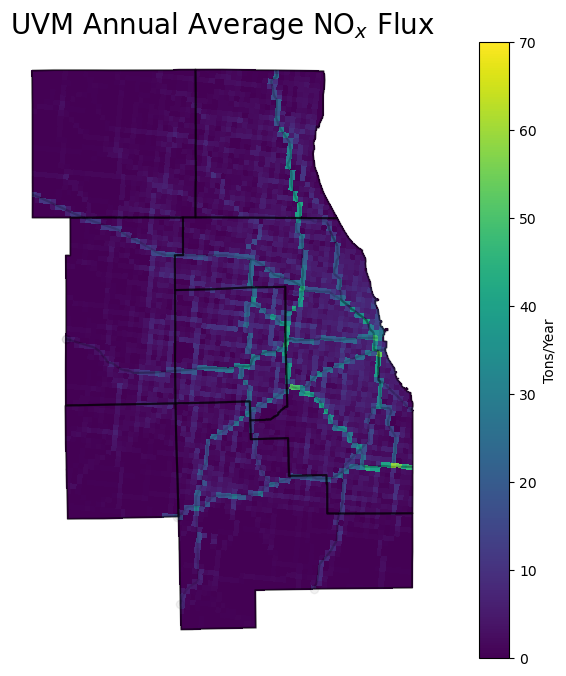

In [19]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_rowan['NOX_flux'] = cmap_rowan['NOX']/(1.33**2)
cmap_rowan.plot('NOX_flux',ax=ax,vmin=0,vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Tons/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('UVM Annual Average NO$_x$ Flux', fontsize=20)
#plt.savefig('rowan_AnnualNOxYear.png', transparent=True)

print('min ',cmap_rowan['NOX_flux'].min())
print('max ',cmap_rowan['NOX_flux'].max())
print('mean ',cmap_rowan['NOX_flux'].mean())
print('median ',cmap_rowan['NOX_flux'].median())
print('mode ',cmap_rowan['NOX_flux'].mode())
print('total',((cmap_rowan['NOX_flux'].sum())))

<h1> Plot CMAP PM2.5 Flux

min  0.0001584788219401888
max  1.481590791799638
mean  0.18348226501107948
median  0.08954880997623635
mode  0    0.001235
Name: PM25_flux, dtype: float64


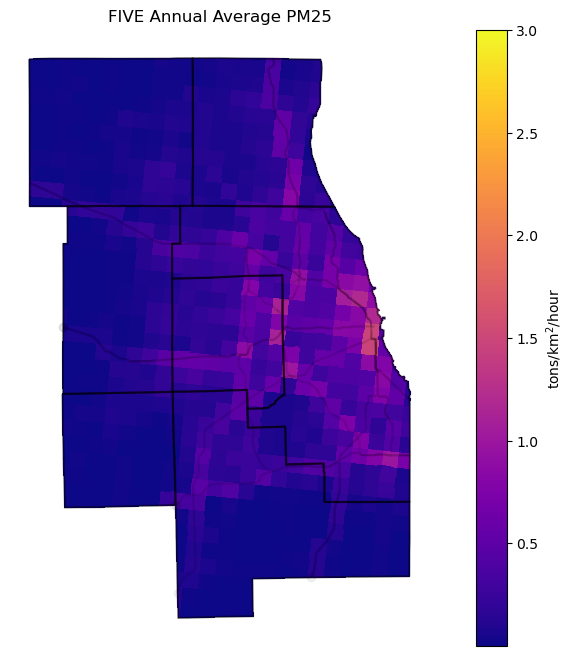

In [20]:
fig,ax = plt.subplots(figsize=((12,8)))

cmap_five['PM25_flux'] = cmap_five['PM25']/(1.33**2)
cmap_five.plot('PM25_flux',ax=ax,vmax=3, legend=True,cmap='plasma', legend_kwds={"label": "tons/km$^2$/hour", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('FIVE Annual Average PM25')

print('min ',cmap_five['PM25_flux'].min())
print('max ',cmap_five['PM25_flux'].max())
print('mean ',cmap_five['PM25_flux'].mean())
print('median ',cmap_five['PM25_flux'].median())
print('mode ',cmap_five['PM25_flux'].mode())

min  2.292458590084233e-09
max  3.5468608341435925
mean  0.17194897266458622
median  0.059634467736505735
mode  0    1.055688e-08
Name: PM25_flux, dtype: float64


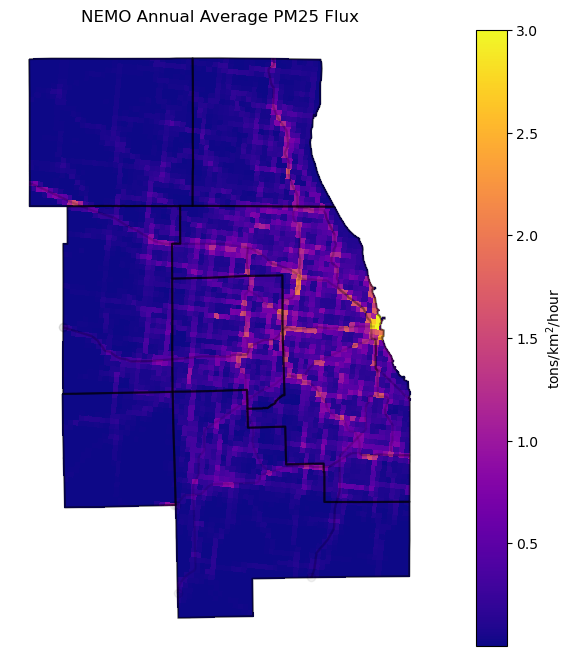

In [21]:
fig,ax = plt.subplots(figsize=((12,8)))

cmap_nemo['PM25_flux'] = cmap_nemo['PM25']/(1.33**2)
cmap_nemo.plot('PM25_flux',ax=ax,vmax=3, legend=True,cmap='plasma', legend_kwds={"label": "tons/km$^2$/hour", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('NEMO Annual Average PM25 Flux')

print('min ',cmap_nemo['PM25_flux'].min())
print('max ',cmap_nemo['PM25_flux'].max())
print('mean ',cmap_nemo['PM25_flux'].mean())
print('median ',cmap_nemo['PM25_flux'].median())
print('mode ',cmap_nemo['PM25_flux'].mode())

min  0.0
max  6.588179932123689
mean  0.16132546528621203
median  0.05526445728947114
mode  0    0.0
Name: PM25_flux, dtype: float64


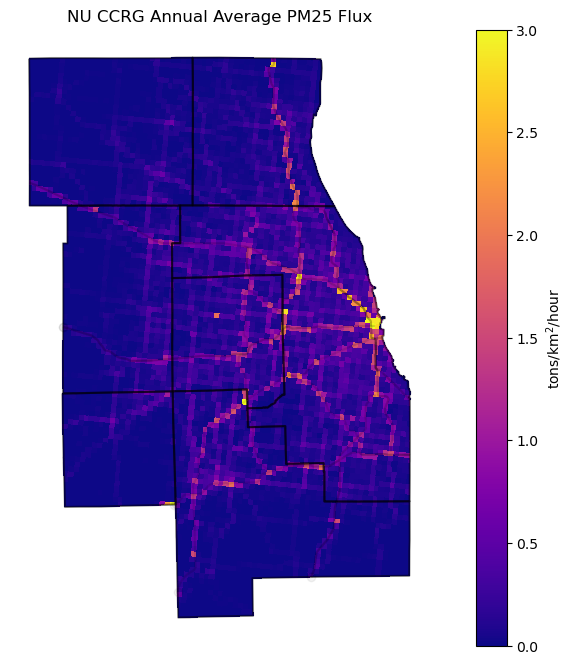

In [22]:
fig,ax = plt.subplots(figsize=((12,8)))

cmap_ladco['PM25_flux'] = cmap_ladco['PM25']/(1.33**2)
cmap_ladco.plot('PM25_flux',ax=ax,vmax=3, legend=True,cmap='plasma', legend_kwds={"label": "tons/km$^2$/hour", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('NU CCRG Annual Average PM25 Flux')

print('min ',cmap_ladco['PM25_flux'].min())
print('max ',cmap_ladco['PM25_flux'].max())
print('mean ',cmap_ladco['PM25_flux'].mean())
print('median ',cmap_ladco['PM25_flux'].median())
print('mode ',cmap_ladco['PM25_flux'].mode())

min  0.0
max  1.612158517349525
mean  0.1085464329516704
median  0.04481841896145486
mode  0    0.0
Name: PM25_flux, dtype: float64


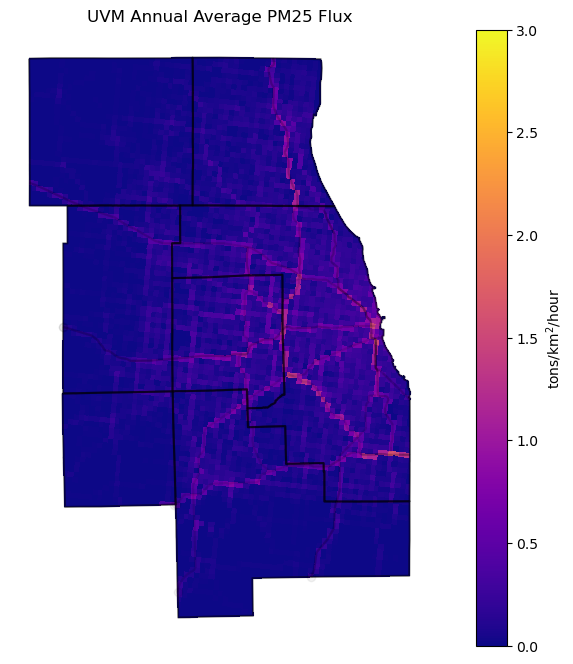

In [23]:
fig,ax = plt.subplots(figsize=((12,8)))

cmap_rowan['PM25_flux'] = cmap_rowan['PM25']/(1.33**2)
cmap_rowan.plot('PM25_flux',ax=ax,vmax=3, legend=True,cmap='plasma', legend_kwds={"label": "tons/km$^2$/hour", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('UVM Annual Average PM25 Flux')

print('min ',cmap_rowan['PM25_flux'].min())
print('max ',cmap_rowan['PM25_flux'].max())
print('mean ',cmap_rowan['PM25_flux'].mean())
print('median ',cmap_rowan['PM25_flux'].median())
print('mode ',cmap_rowan['PM25_flux'].mode())

<h1> Plot CMAP NOx Emissions

max  76.69291687011719
mean  9.430188617783275
median  4.771611452102661
sum  57241.24490994448


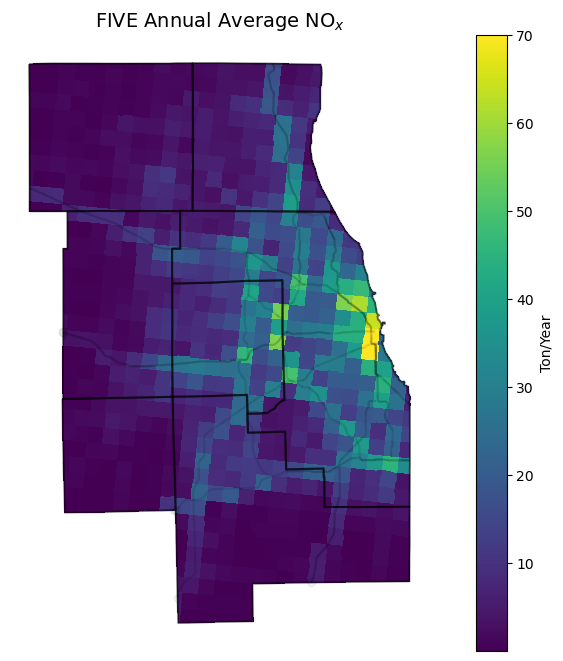

In [24]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_five.plot('NOX',ax=ax,vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('FIVE Annual Average NO$_x$',fontsize=14)

print('max ',cmap_five['NOX'].max())
print('mean ',cmap_five['NOX'].mean())
print('median ',cmap_five['NOX'].median())
print('sum ',cmap_five['NOX'].sum())

Text(0.5, 1.0, 'FIVE Annual Average NOx (1.33 km)')

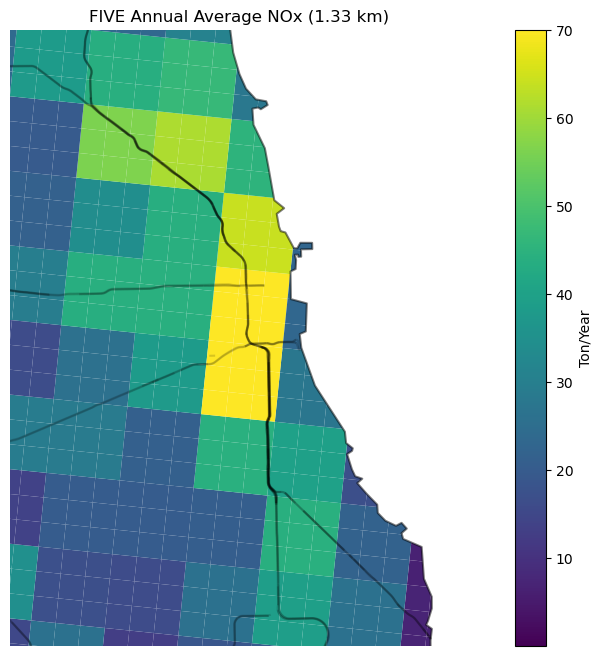

In [25]:
#cmap_five['NOX_flux'] = cmap_five['NOX']/(1.33**2)
fig,ax = plt.subplots(figsize=((12,8)))
cmap_five.plot('NOX',ax=ax,vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"})#,antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
ax.set_xlim(-87.8, -87.5,)
ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('FIVE Annual Average NOx (1.33 km)')
#(cmap_five['NOX']/(1.33**2).sum())

min  7.6784254e-08
max  138.54762268066406
mean  5.177111193052183
median  2.09070885181427
sum  31425.064941826753


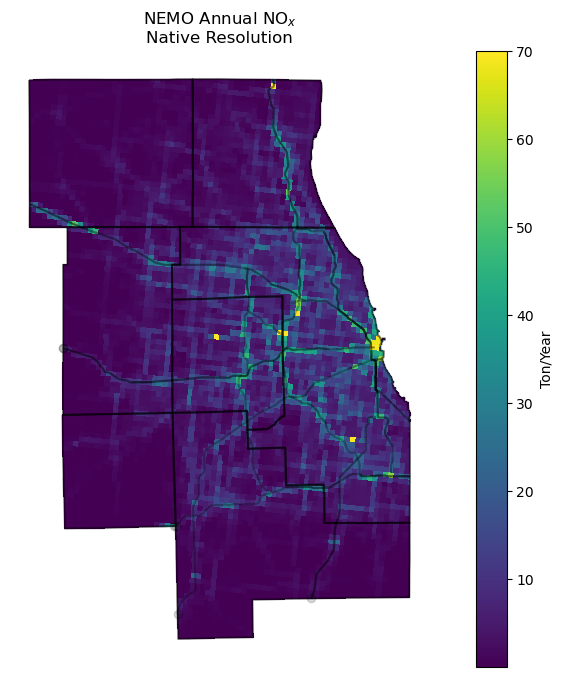

In [26]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_nemo.plot('NOX',ax=ax,vmax=70,legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
ax.set_axis_off()
plt.title('NEMO Annual NO$_x$\nNative Resolution')

print('min ', cmap_nemo['NOX'].min())
print('max ', cmap_nemo['NOX'].max())
print('mean ', cmap_nemo['NOX'].mean())
print('median ', cmap_nemo['NOX'].median())
print('sum ', cmap_nemo['NOX'].sum())

Text(0.5, 1.0, 'NEMO Annual Average NO$_x$)')

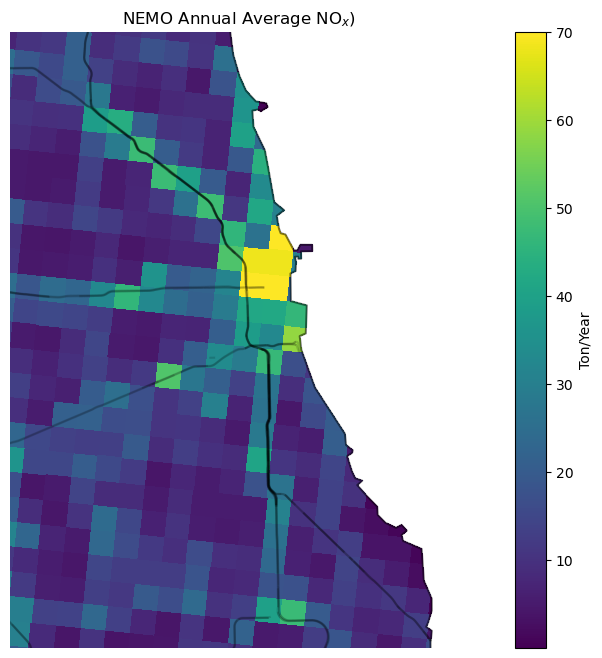

In [27]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_nemo.plot('NOX',ax=ax, vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
ax.set_xlim(-87.8, -87.5,)
ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('NEMO Annual Average NO$_x$)')
#print((cmap_nemo['nemo_metricNOX']).sum())

min  0.0
max  241.0995635986328
mean  5.91776598105454
median  1.762624502182007
sum  35920.83950500106


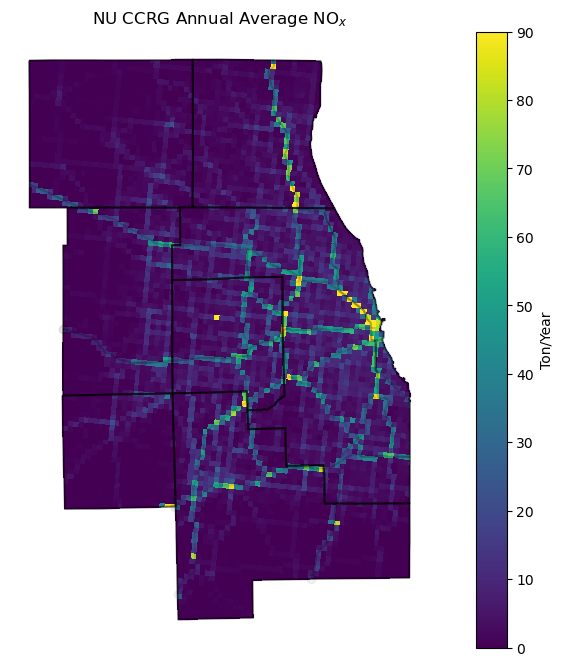

In [28]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('NOX',ax=ax,vmax=90, legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)

ax.set_axis_off()
plt.title('NU CCRG Annual Average NO$_x$')

print('min ', cmap_ladco['NOX'].min())
print('max ', cmap_ladco['NOX'].max())
print('mean ', cmap_ladco['NOX'].mean())
print('median ', cmap_ladco['NOX'].median())
print('sum ', cmap_ladco['NOX'].sum())

min  0.0
max  241.0995635986328


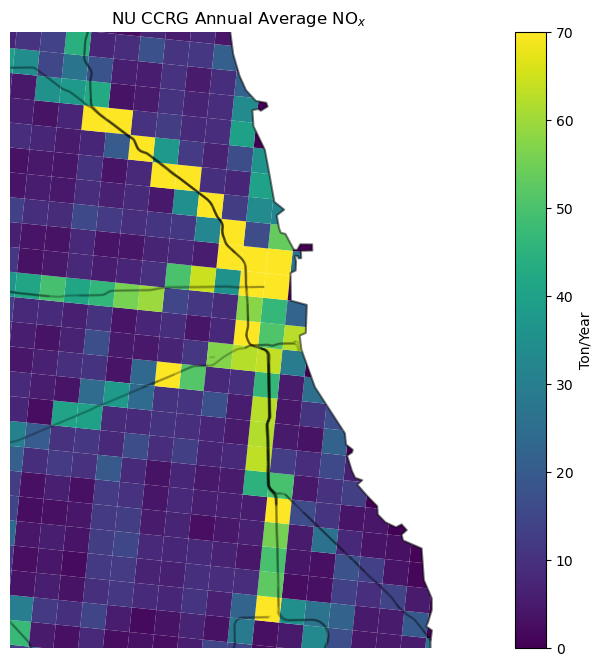

In [29]:
cmap_ladco['NOX']
fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('NOX',ax=ax,vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
ax.set_xlim(-87.8, -87.5,)
ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('NU CCRG Annual Average NO$_x$')

print('min ', cmap_ladco['NOX'].min())
print('max ', cmap_ladco['NOX'].max())

min  0.0
max  104.372338044123
mean  5.99290647323791
median  2.2584009728558474
sum  36376.942292554115


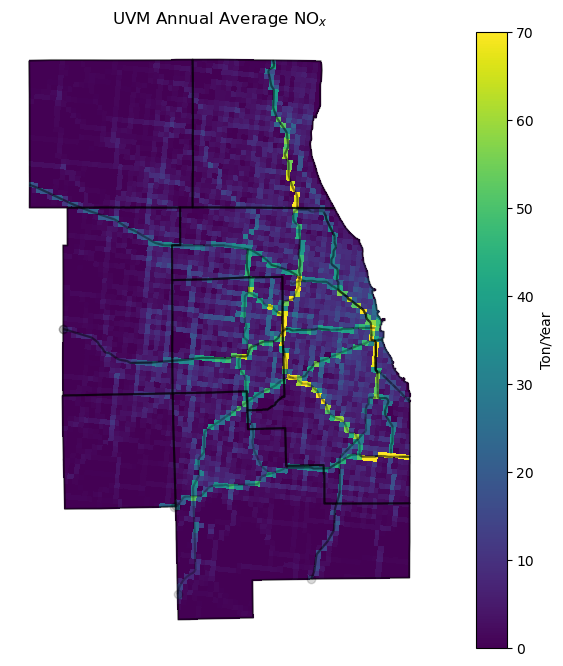

In [30]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_rowan.plot('NOX',ax=ax,vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
ax.set_axis_off()
plt.title('UVM Annual Average NO$_x$')

print('min ', cmap_rowan['NOX'].min())
print('max ', cmap_rowan['NOX'].max())
print('mean ', cmap_rowan['NOX'].mean())
print('median ', cmap_rowan['NOX'].median())
print('sum ', cmap_rowan['NOX'].sum())

Text(0.5, 1.0, 'UVM Annual Average NO$_x$')

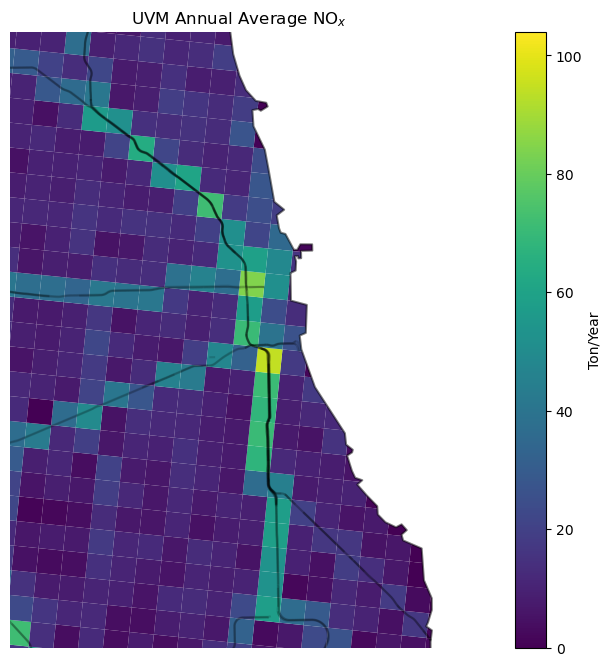

In [31]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_rowan.plot('NOX',ax=ax,vmax=104, legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"}),#antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
ax.set_xlim(-87.8, -87.5,)
ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('UVM Annual Average NO$_x$')

<h1> Plot PM2.5 Emissions

min  0.00028033318813
max  2.62078595161438
mean  0.3245617785780985
median  0.1584028899669645
sum  1970.0899959690578


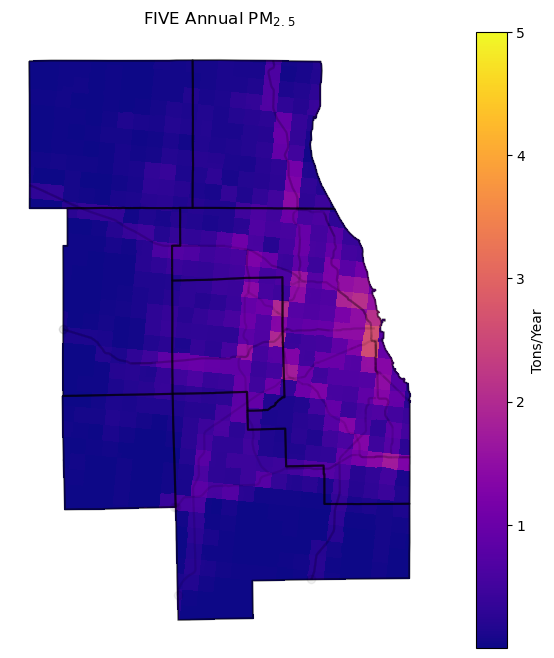

In [32]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_five.plot('PM25',ax=ax,vmax=5, legend=True,cmap='plasma', legend_kwds={"label": "Tons/Year",  
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('FIVE Annual PM$_2$$_.$$_5$')

print('min ',cmap_five['PM25'].min())
print('max ',cmap_five['PM25'].max())
print('mean ',cmap_five['PM25'].mean())
print('median ',cmap_five['PM25'].median())
print('sum ',cmap_five['PM25'].sum())

Text(0.5, 1.0, 'FIVE Annual Average PM$_2$$_.$$_5$')

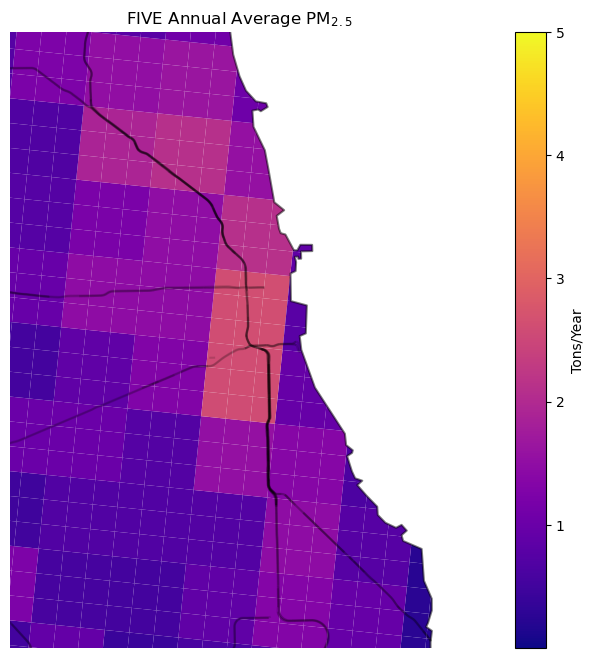

In [33]:
#cmap_five['PM25_flux'] = cmap_five['PM25']/(1.33**2)
fig,ax = plt.subplots(figsize=((12,8)))
cmap_five.plot('PM25',ax=ax,vmax=5, legend=True,cmap='plasma', legend_kwds={"label": "Tons/Year", 
                                                     "orientation":"vertical"})#,antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
ax.set_xlim(-87.8, -87.5,)
ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('FIVE Annual Average PM$_2$$_.$$_5$')

min  4.05513e-09
max  6.274042129516602
mean  0.30416053774638663
median  0.105487409979105
sum  1846.2544641205668


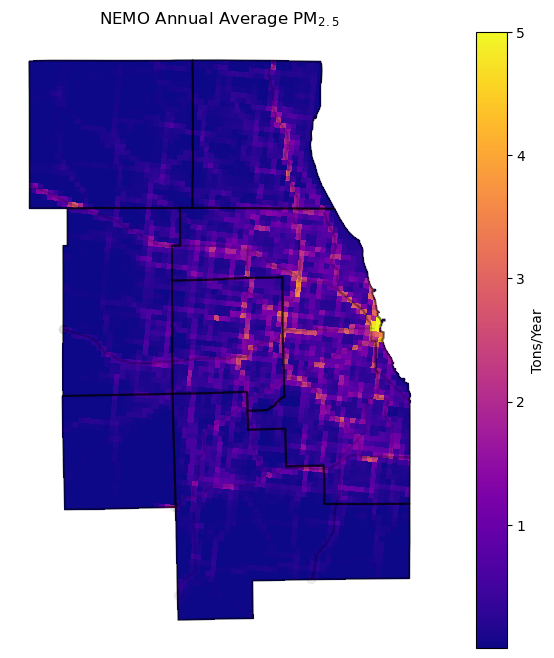

In [34]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_nemo.plot('PM25',ax=ax,vmax=5,legend=True,cmap='plasma', legend_kwds={"label":"Tons/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('NEMO Annual Average PM$_2$$_.$$_5$')

print('min ', cmap_nemo['PM25'].min())
print('max ', (cmap_nemo['PM25']).max())
print('mean ', cmap_nemo['PM25'].mean())
print('median ', cmap_nemo['PM25'].median())
print('sum ', cmap_nemo['PM25'].sum())

Text(0.5, 1.0, 'NEMO Annual Average PM25')

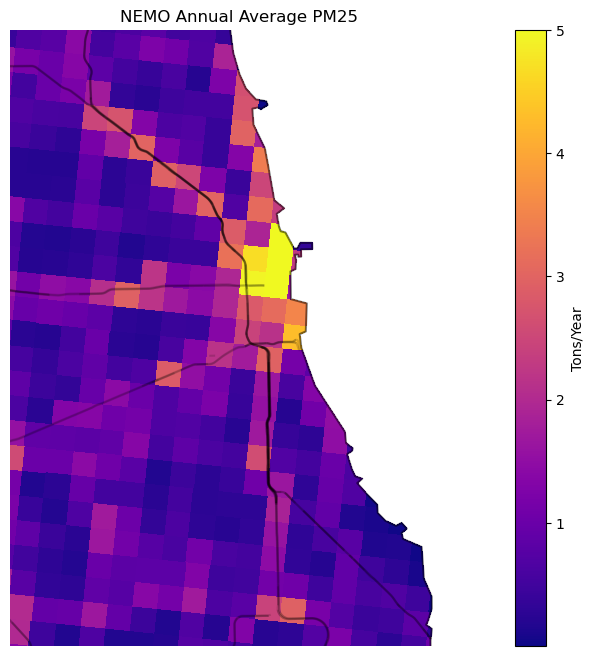

In [35]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_nemo.plot('PM25',ax=ax, vmax=5, legend=True,cmap='plasma', legend_kwds={"label": "Tons/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
ax.set_xlim(-87.8, -87.5,)
ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('NEMO Annual Average PM25')

min  0.0
max  11.653831481933594
mean  0.2853686155447805
median  0.0977572984993455
sum  1732.1874963568175


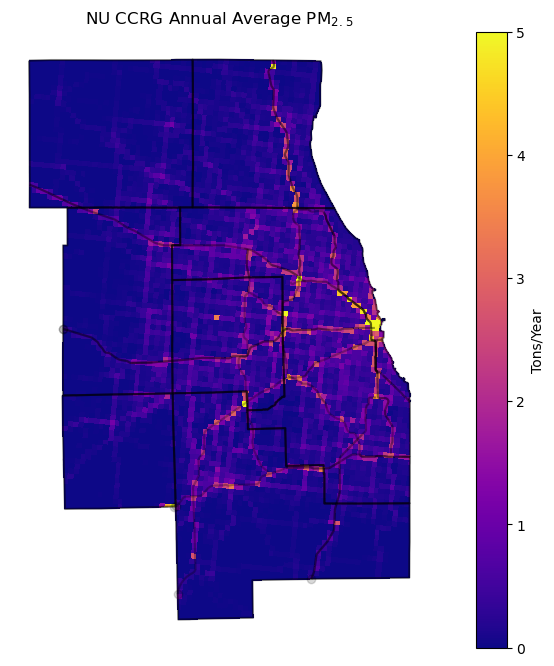

In [36]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('PM25',ax=ax,vmax=5, legend=True,cmap='plasma', legend_kwds={"label": "Tons/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

ax.set_axis_off()
plt.title('NU CCRG Annual Average PM$_2$$_.$$_5$')

print('min ', cmap_ladco['PM25'].min())
print('max ', cmap_ladco['PM25'].max())
print('mean ', cmap_ladco['PM25'].mean())
print('median ', cmap_ladco['PM25'].median())
print('sum ', cmap_ladco['PM25'].sum())

Text(0.5, 1.0, 'NU CCRG Annual Average PM$_2$$_.$$_5$')

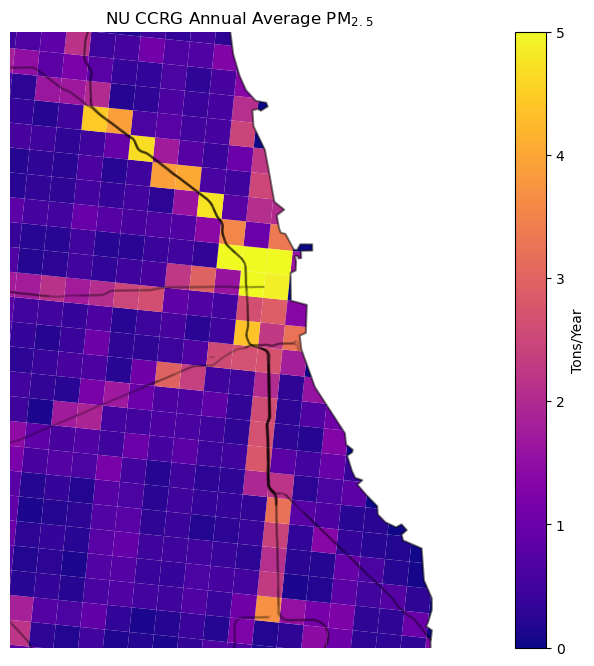

In [37]:
cmap_ladco['PM25']
fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('PM25',ax=ax,vmax=5, legend=True,cmap='plasma', legend_kwds={"label": "Tons/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
ax.set_xlim(-87.8, -87.5,)
ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('NU CCRG Annual Average PM$_2$$_.$$_5$')

min  0.0
max  2.851747201339575
mean  0.19200778524820977
median  0.07927930130091751
sum  1165.4872564566333


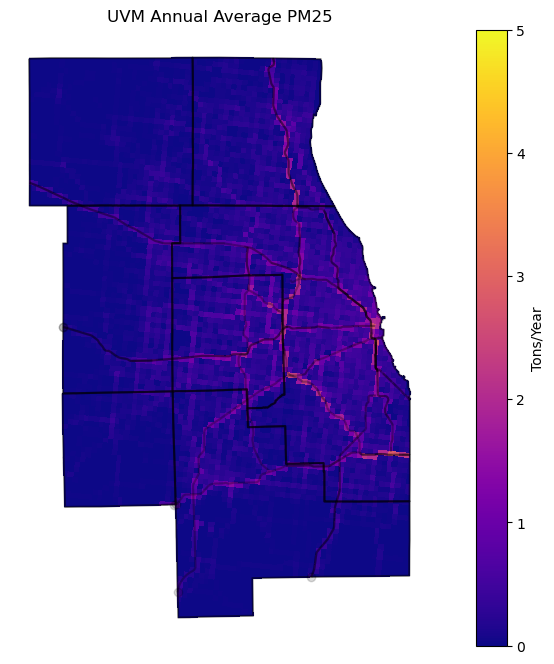

In [38]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_rowan.plot('PM25',ax=ax,vmax=5, legend=True,cmap='plasma', legend_kwds={"label":"Tons/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
ax.set_axis_off()
plt.title('UVM Annual Average PM25')

print('min ', cmap_rowan['PM25'].min())
print('max ', cmap_rowan['PM25'].max())
print('mean ', cmap_rowan['PM25'].mean())
print('median ', cmap_rowan['PM25'].median())
print('sum ', cmap_rowan['PM25'].sum())

Text(0.5, 1.0, 'UVM Annual Average PM$_2$$_.$$_5$')

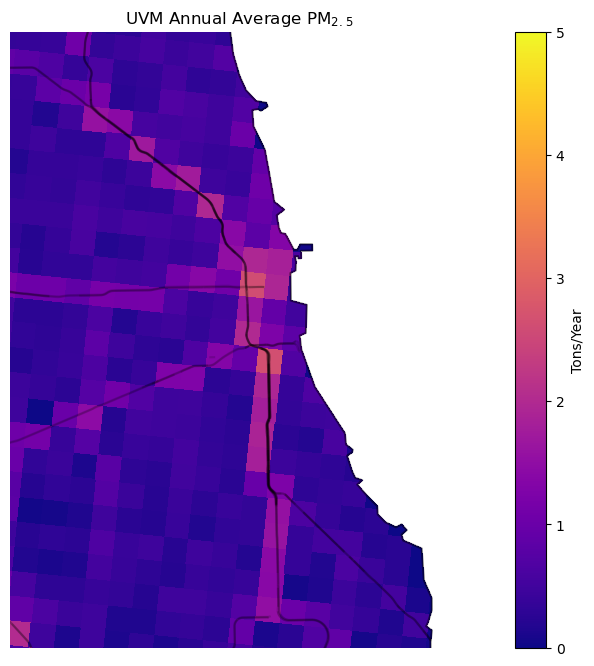

In [39]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_rowan.plot('PM25',ax=ax,vmax=5, legend=True,cmap='plasma', legend_kwds={"label":"Tons/Year",  
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
ax.set_xlim(-87.8, -87.5,)
ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('UVM Annual Average PM$_2$$_.$$_5$')

<h1> Plot NOx mean and standard deviation

In [40]:
cmap_ladco['NOx_sum'] = (cmap_ladco['NOX'] + cmap_rowan['NOX']  +  cmap_nemo['NOX'] +  cmap_five['NOX'])
cmap_ladco['NOx_mean'] = cmap_ladco['NOx_sum']/4

0.00174816629350975
119.06695553360319
mean  6.629493066281976
median  3.0945558247616
sum  40241.022912331595


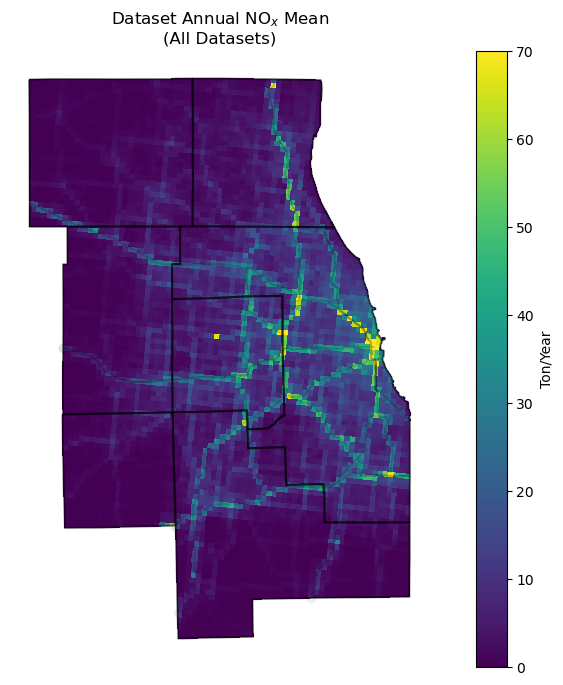

In [41]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('NOx_mean',ax=ax,vmin=0, vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('Dataset Annual NO$_x$ Mean\n(All Datasets)')
print(cmap_ladco['NOx_mean'].min())
print(cmap_ladco['NOx_mean'].max())
print('mean ',cmap_ladco['NOx_mean'].mean())
print('median ', cmap_ladco['NOx_mean'].median())
print('sum ', cmap_ladco['NOx_mean'].sum())

Text(0.5, 1.0, 'Annual NO$_x$ Mean')

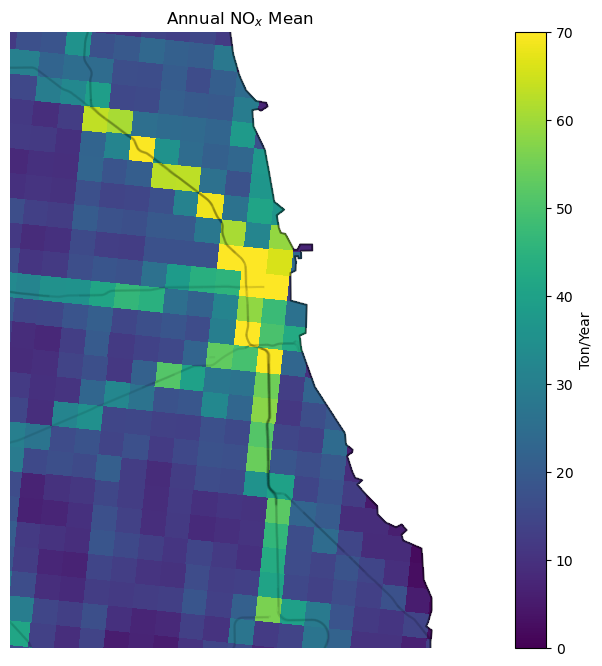

In [42]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('NOx_mean',ax=ax,vmin=0, vmax=70, legend=True,cmap='viridis', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_xlim(-87.8, -87.5,)
ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('Annual NO$_x$ Mean')

In [43]:
cmap_ladco['nox_std_dev'] = np.sqrt(((cmap_ladco['NOX'] - cmap_ladco['NOx_mean'])**2 + (cmap_rowan['NOX']- cmap_ladco['NOx_mean'])**2 
                                +(cmap_nemo['NOX']- cmap_ladco['NOx_mean'])**2  +  (cmap_five['NOX']- cmap_ladco['NOx_mean'])**2)/3)

In [44]:
cmap_rowan['nox_std_dev'] = cmap_ladco['nox_std_dev']
cmap_five['nox_std_dev'] = cmap_ladco['nox_std_dev']
cmap_nemo['nox_std_dev'] = cmap_ladco['nox_std_dev']

0.0032922663831293905
81.47269921942674


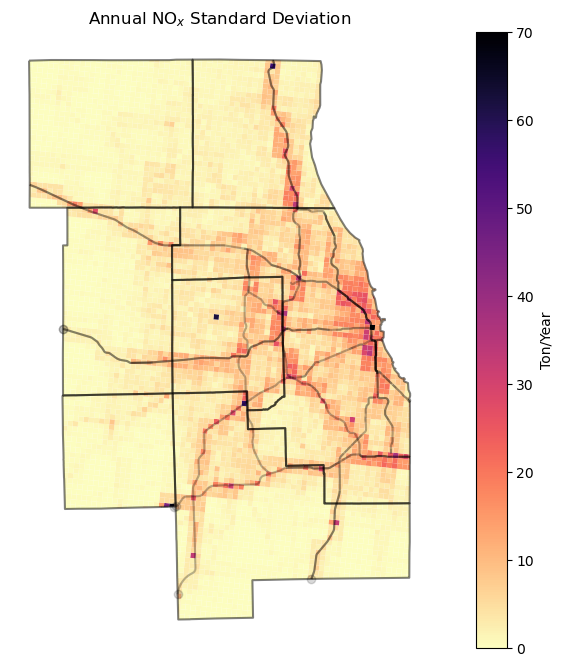

In [45]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('nox_std_dev',ax=ax,vmin=0,vmax=70, legend=True,cmap='magma_r', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
# ax.set_xlim(-87.8, -87.5,)
# ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('Annual NO$_x$ Standard Deviation')
print(cmap_ladco['nox_std_dev'].min())
print(cmap_ladco['nox_std_dev'].max())

<h1> Plot PM25 mean and standard deviation

In [46]:
cmap_ladco['PM25_sum'] = (cmap_ladco['PM25'] + cmap_rowan['PM25']  +  cmap_nemo['PM25'] +  cmap_five['PM25'])
cmap_ladco['PM25_mean'] = cmap_ladco['PM25_sum']/4

7.034694567675e-05
5.4576247908845215
mean  0.2765246792793688
median  0.12775937644596164
sum  1678.5048032257687


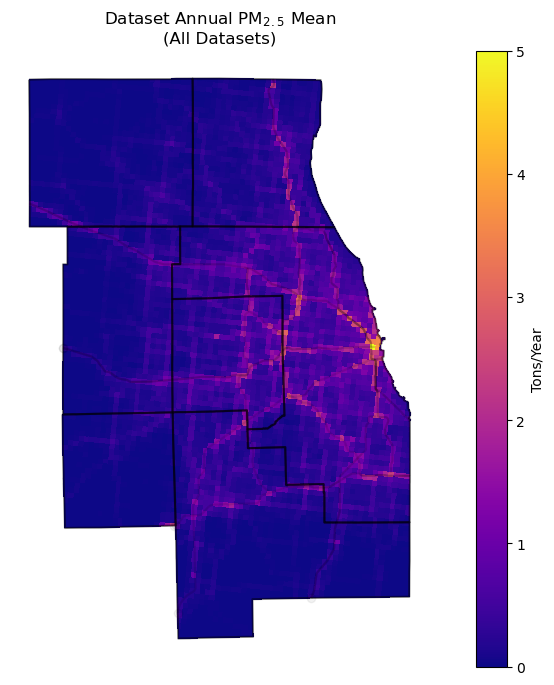

In [47]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('PM25_mean',ax=ax,vmin=0, vmax=5, legend=True,cmap='plasma', legend_kwds={"label": "Tons/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_axis_off()
plt.title('Dataset Annual PM$_2$$_.$$_5$ Mean\n(All Datasets)')
print(cmap_ladco['PM25_mean'].min())
print(cmap_ladco['PM25_mean'].max())
print('mean ',cmap_ladco['PM25_mean'].mean())
print('median ', cmap_ladco['PM25_mean'].median())
print('sum ', cmap_ladco['PM25_mean'].sum())

Text(0.5, 1.0, 'Annual PM$_2$$_.$$_5$ Mean')

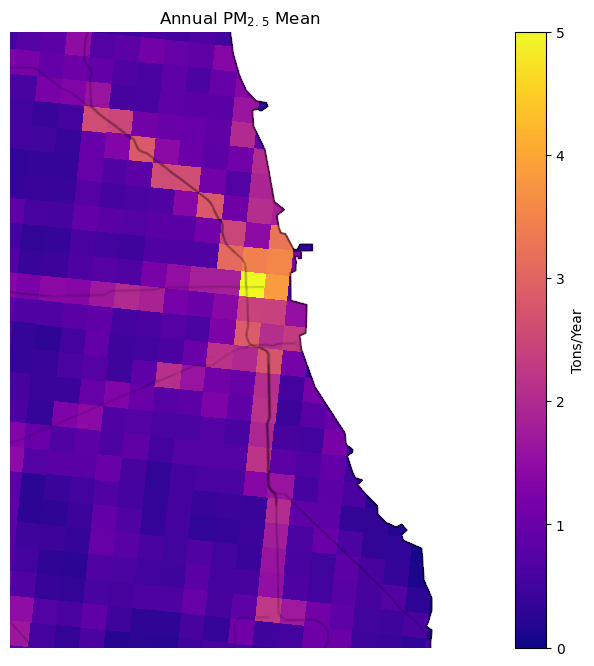

In [48]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('PM25_mean',ax=ax,vmin=0, vmax=5, legend=True,cmap='plasma', legend_kwds={"label": "Tons/Year", 
                                                     "orientation":"vertical"},antialiased=False)
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.05)
ax.set_xlim(-87.8, -87.5,)
ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('Annual PM$_2$$_.$$_5$ Mean')

In [49]:
cmap_ladco['pm25_std_dev'] = np.sqrt(((cmap_ladco['PM25'] - cmap_ladco['PM25_mean'])**2 + (cmap_rowan['PM25']- cmap_ladco['PM25_mean'])**2 
                                +(cmap_nemo['PM25']- cmap_ladco['PM25_mean'])**2  +  (cmap_five['PM25']- cmap_ladco['PM25_mean'])**2)/3)

In [50]:
cmap_rowan['pm25_std_dev'] = cmap_ladco['pm25_std_dev']
cmap_five['pm25_std_dev'] = cmap_ladco['pm25_std_dev']
cmap_nemo['pm25_std_dev'] = cmap_ladco['pm25_std_dev']

0.00013523921085849716
4.273756371209595


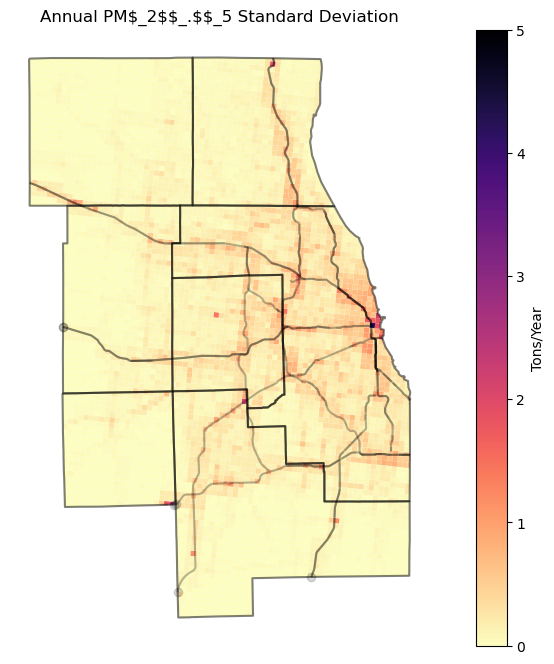

In [51]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('pm25_std_dev',ax=ax,vmin=0,vmax=5, legend=True,cmap='magma_r', legend_kwds={"label":"Tons/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

ax.set_axis_off()
plt.title('Annual PM$_2$$_.$$_5 Standard Deviation')
print(cmap_ladco['pm25_std_dev'].min())
print(cmap_ladco['pm25_std_dev'].max())

Text(0.5, 1.0, 'Annual PM$_2$$_.$$_5$ Standard Deviation')

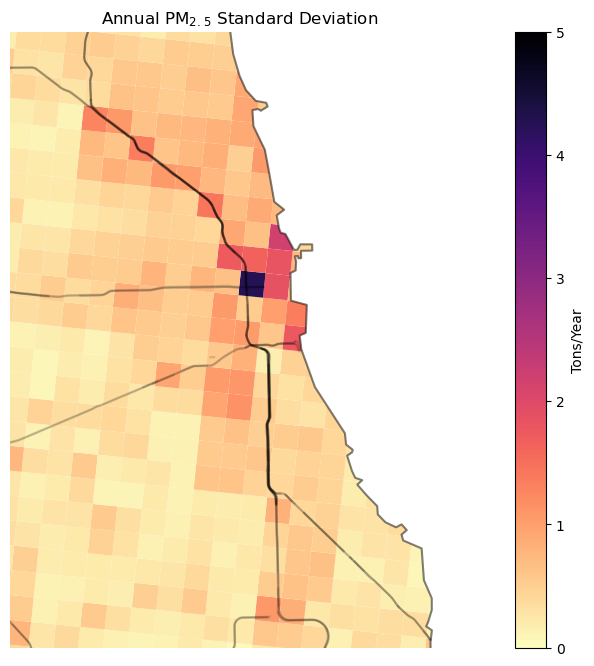

In [52]:
fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('pm25_std_dev',ax=ax,vmin=0,vmax=5, legend=True,cmap='magma_r', legend_kwds={"label":"Tons/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)
ax.set_xlim(-87.8, -87.5,)
ax.set_ylim(41.7, 42)
ax.set_axis_off()
plt.title('Annual PM$_2$$_.$$_5$ Standard Deviation')

<h1> Plot NOx versus mean differences 

max  50.97492668330893
min  -55.05242772301065


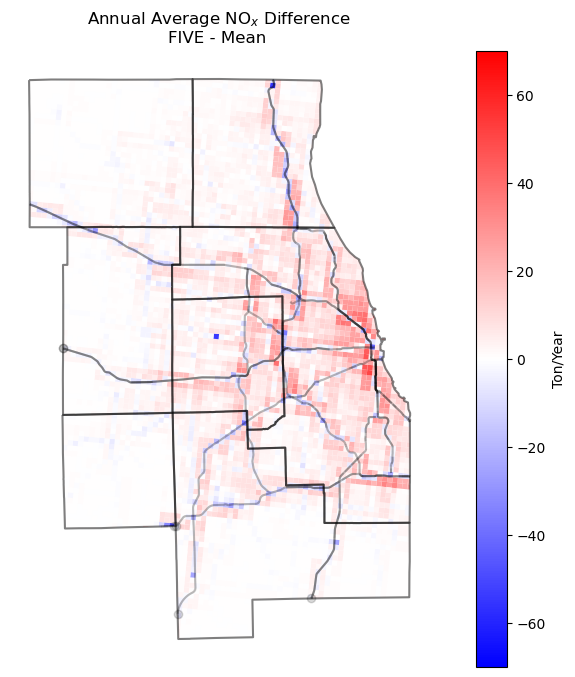

In [53]:
cmap_five['NOx_minus_mean'] = cmap_five['NOX'] - cmap_ladco['NOx_mean'] 

fig,ax = plt.subplots(figsize=((12,8)))
cmap_five.plot('NOx_minus_mean',ax=ax, vmin=-70, vmax=70, legend=True,cmap='bwr', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

ax.set_axis_off()
plt.title('Annual Average NO$_x$ Difference \nFIVE - Mean ')
print('max ',cmap_five['NOx_minus_mean'].max())
print('min ',cmap_five['NOx_minus_mean'].min())

max  71.82850448878486
min  -44.98397823868132


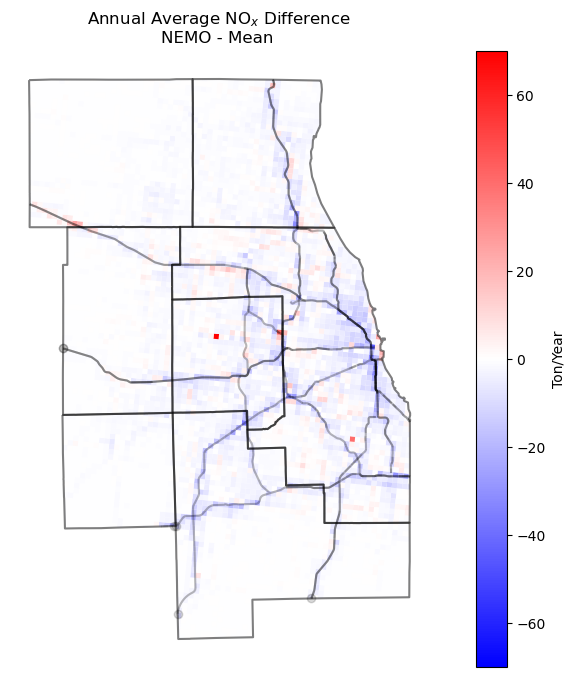

In [54]:
cmap_nemo['NOx_minus_mean'] = cmap_nemo['NOX'] - cmap_ladco['NOx_mean'] 

fig,ax = plt.subplots(figsize=((12,8)))
cmap_nemo.plot('NOx_minus_mean',ax=ax, vmin=-70, vmax=70, legend=True,cmap='bwr', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

ax.set_axis_off()
plt.title('Annual Average NO$_x$ Difference \nNEMO - Mean ')
print('max ',cmap_nemo['NOx_minus_mean'].max())
print('min ',cmap_nemo['NOx_minus_mean'].min())

max  122.03260806502962
min  -28.014299313488863


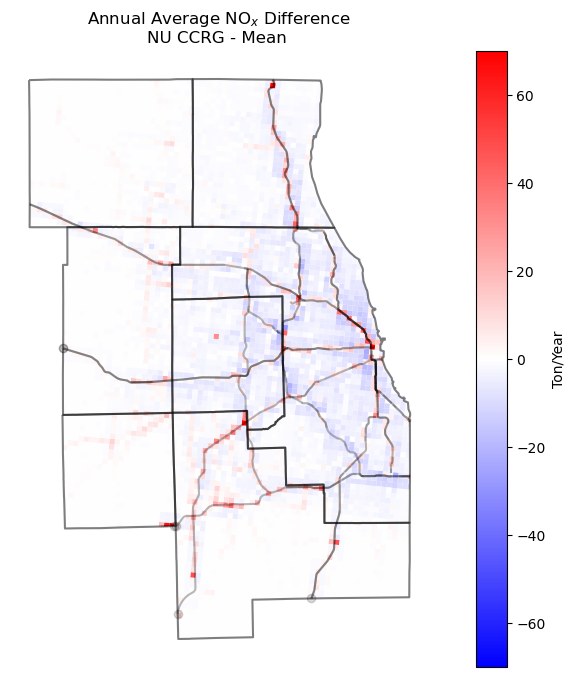

In [55]:
cmap_ladco['NOx_minus_mean'] = cmap_ladco['NOX'] - cmap_ladco['NOx_mean'] 

fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('NOx_minus_mean',ax=ax,vmin=-70, vmax=70, legend=True,cmap='bwr', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

ax.set_axis_off()
plt.title('Annual Average NO$_x$ Difference \nNU CCRG - Mean ')
print('max ',cmap_ladco['NOx_minus_mean'].max())
print('min ',cmap_ladco['NOx_minus_mean'].min())

In [56]:
cmap_rowan['NOx_minus_mean'] = cmap_rowan['NOX'] - cmap_ladco['NOx_mean'] 

fig,ax = plt.subplots(figsize=((12,8)))
cmap_rowan.plot('NOx_minus_mean',ax=ax, vmin=-70, vmax=70, legend=True,cmap='bwr', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

ax.set_axis_off()
plt.title('Annual Average NO$_x$ Difference \nUVM - Mean ')
print('max ',cmap_rowan['NOx_minus_mean'].max())
print('min ',cmap_rowan['NOx_minus_mean'].min())

max  52.1078394034652
min  -49.34104992723101


<h1> Plot PM25 versus mean differences 

max  1.7185617840329102
min  -2.8368388392701416


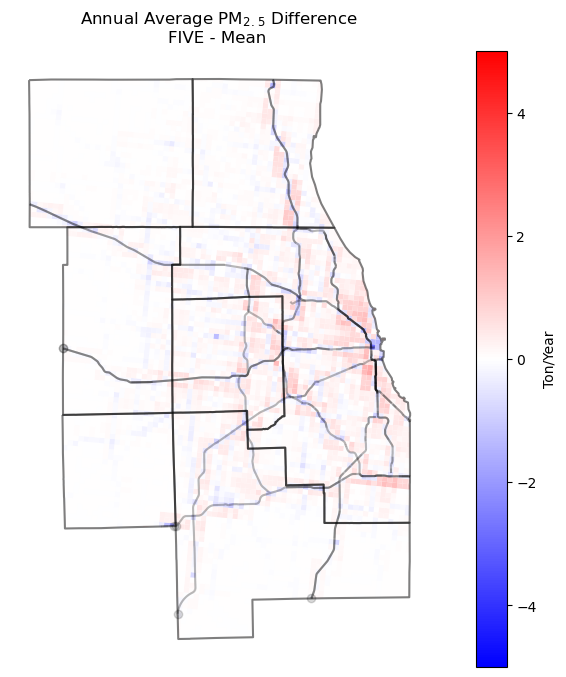

In [57]:
cmap_five['PM25_minus_mean'] = cmap_five['PM25'] - cmap_ladco['PM25_mean'] 

fig,ax = plt.subplots(figsize=((12,8)))
cmap_five.plot('PM25_minus_mean',ax=ax,vmin=-5, vmax=5, legend=True,cmap='bwr', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

ax.set_axis_off()
plt.title('Annual Average PM$_2$$_.$$_5$ Difference \nFIVE - Mean ')
print('max ',cmap_five['PM25_minus_mean'].max())
print('min ',cmap_five['PM25_minus_mean'].min())

max  3.0157310045963883
min  -0.868715410650315


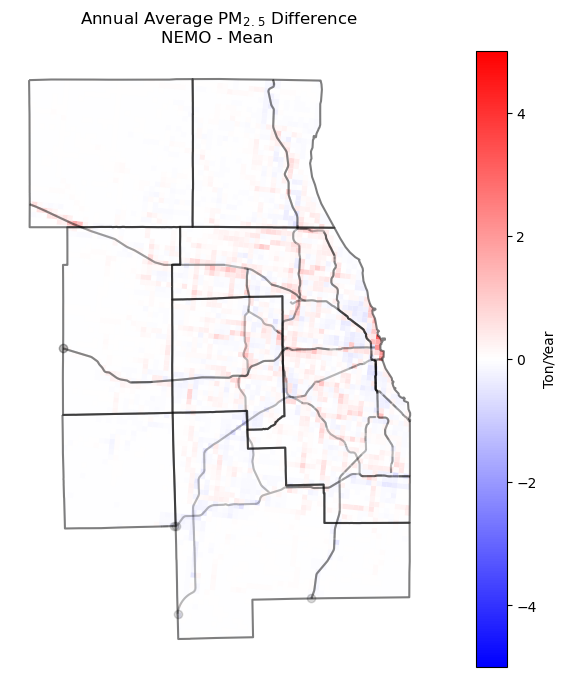

In [58]:
cmap_nemo['PM25_minus_mean'] = cmap_nemo['PM25'] - cmap_ladco['PM25_mean'] 

fig,ax = plt.subplots(figsize=((12,8)))
cmap_nemo.plot('PM25_minus_mean',ax=ax,vmin=-5, vmax=5,  legend=True,cmap='bwr', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

ax.set_axis_off()
plt.title('Annual Average PM$_2$$_.$$_5$ Difference \nNEMO - Mean ')
print('max ',cmap_nemo['PM25_minus_mean'].max())
print('min ',cmap_nemo['PM25_minus_mean'].min())

max  6.196206691049072
min  -0.9523080826056717


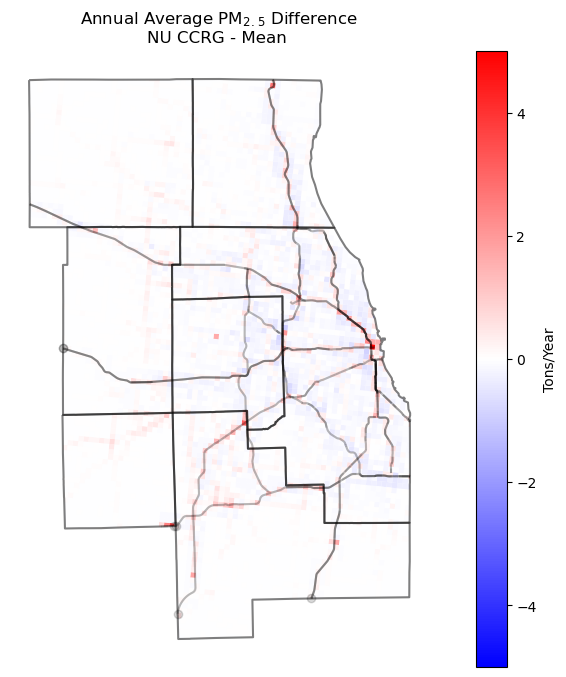

In [59]:
cmap_ladco['PM25_minus_mean'] = cmap_ladco['PM25'] - cmap_ladco['PM25_mean'] 

fig,ax = plt.subplots(figsize=((12,8)))
cmap_ladco.plot('PM25_minus_mean',ax=ax,vmin=-5, vmax=5,  legend=True,cmap='bwr', legend_kwds={"label": "Tons/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

ax.set_axis_off()
plt.title('Annual Average PM$_2$$_.$$_5$ Difference \nNU CCRG - Mean ')
print('max ',cmap_ladco['PM25_minus_mean'].max())
print('min ',cmap_ladco['PM25_minus_mean'].min())

In [60]:
cmap_rowan['PM25_minus_mean'] = cmap_rowan['PM25'] - cmap_ladco['PM25_mean'] 

fig,ax = plt.subplots(figsize=((12,8)))
cmap_rowan.plot('PM25_minus_mean',ax=ax,vmin=-5, vmax=5,  legend=True,cmap='bwr', legend_kwds={"label": "Ton/Year", 
                                                     "orientation":"vertical"})
cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

ax.set_axis_off()
plt.title('Annual Average PM$_2$$_.$$_5$ Difference \nUVM - Mean ')
print('max ',cmap_rowan['PM25_minus_mean'].max())
print('min ',cmap_rowan['PM25_minus_mean'].min())

max  1.1175150374699578
min  -2.8440877264217517


<h1> Plot grid cells in which NOX values are outside 1 std deviation from the mean 

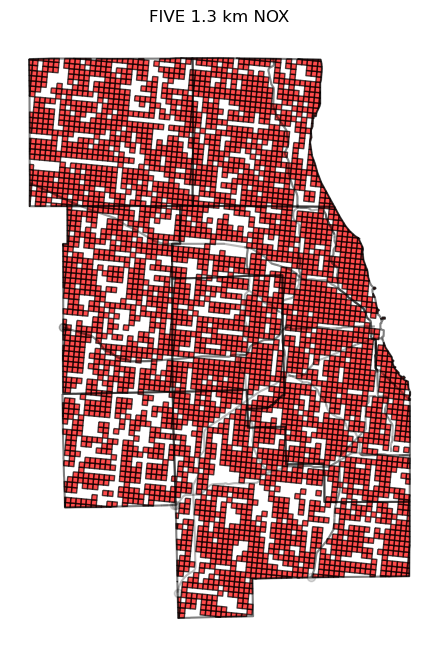

In [61]:
# Calculate the difference between NOX and NOx_mean
cmap_five['NOX_difference'] = cmap_five['NOX'] - cmap_ladco['NOx_mean']

# Identify polygons where the difference is greater than 2 times the standard deviation
mask = np.abs(cmap_five['NOX_difference']) >= 1 * cmap_five['nox_std_dev']
selected_polygons = cmap_five[mask]

# Plot the polygons
fig,ax = plt.subplots(figsize=((12,8)))
selected_polygons.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

# Set a finite and positive aspect ratio
#ax.set_aspect('equal')
ax.set_axis_off()
plt.title('FIVE 1.3 km NOX')
plt.show()


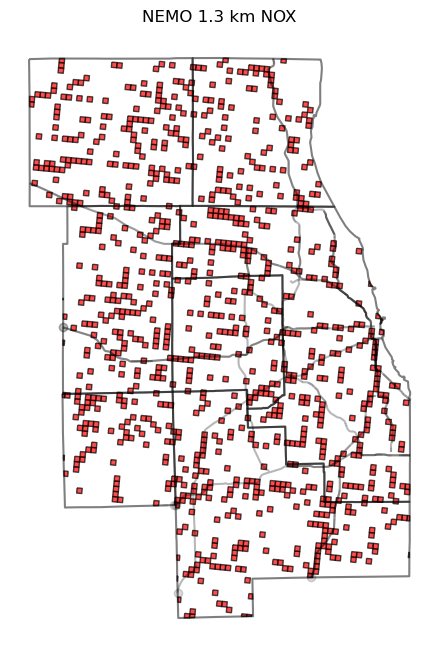

In [62]:
# Calculate the difference between NOX and NOx_mean
cmap_nemo['NOX_difference'] = cmap_nemo['NOX'] - cmap_ladco['NOx_mean']

# Identify polygons where the difference is greater than 2 times the standard deviation
mask = np.abs(cmap_nemo['NOX_difference']) >= 1 * cmap_nemo['nox_std_dev']
selected_polygons = cmap_nemo[mask]

# Plot the polygons
fig,ax = plt.subplots(figsize=((12,8)))

selected_polygons.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

# Set a finite and positive aspect ratio
#ax.set_aspect('equal')
ax.set_axis_off()
plt.title('NEMO 1.3 km NOX')
plt.show()

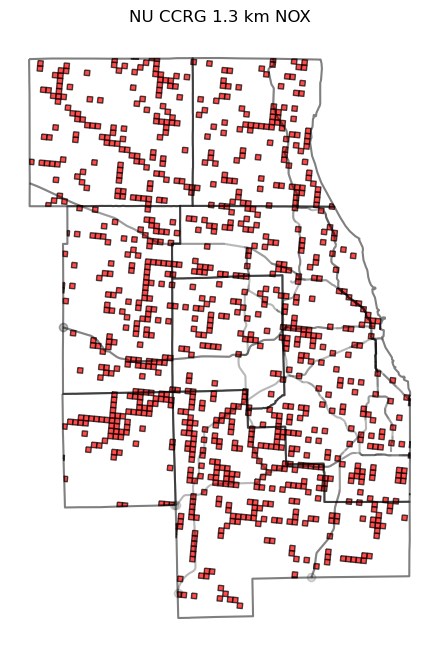

In [63]:
# Calculate the difference between NOX and NOx_mean
cmap_ladco['NOX_difference'] = cmap_ladco['NOX'] - cmap_ladco['NOx_mean']

# Identify polygons where the difference is greater than 2 times the standard deviation
mask = np.abs(cmap_ladco['NOX_difference']) >= 1 * cmap_ladco['nox_std_dev']
selected_polygons = cmap_ladco[mask]

# Plot the polygons
fig,ax = plt.subplots(figsize=((12,8)))
selected_polygons.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

# Set a finite and positive aspect ratio
#ax.set_aspect('equal')
ax.set_axis_off()
plt.title('NU CCRG 1.3 km NOX')
plt.show()

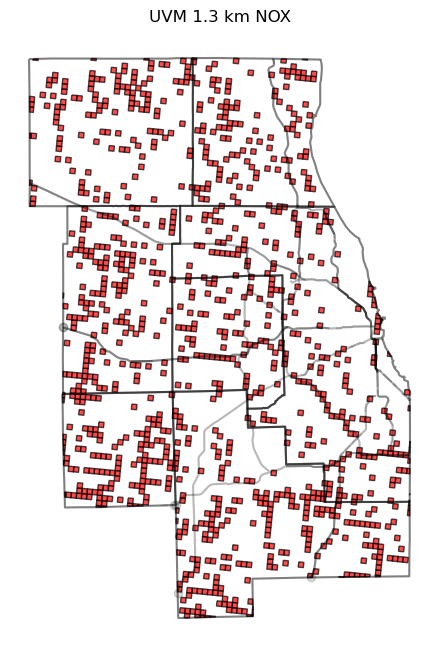

In [64]:
# Calculate the difference between NOX and NOx_mean
cmap_rowan['NOX_difference'] = cmap_rowan['NOX'] - cmap_ladco['NOx_mean']

# Identify polygons where the difference is greater than 2 times the standard deviation
mask = np.abs(cmap_rowan['NOX_difference']) >= 1 * cmap_rowan['nox_std_dev']
selected_polygons = cmap_rowan[mask]

# Plot the polygons
fig,ax = plt.subplots(figsize=((12,8)))
selected_polygons.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

# Set a finite and positive aspect ratio
#ax.set_aspect('equal')
ax.set_axis_off()
plt.title('UVM 1.3 km NOX')
plt.show()


<h1> Plot gridcells that exceed 1 std deviation of mean pm2.5

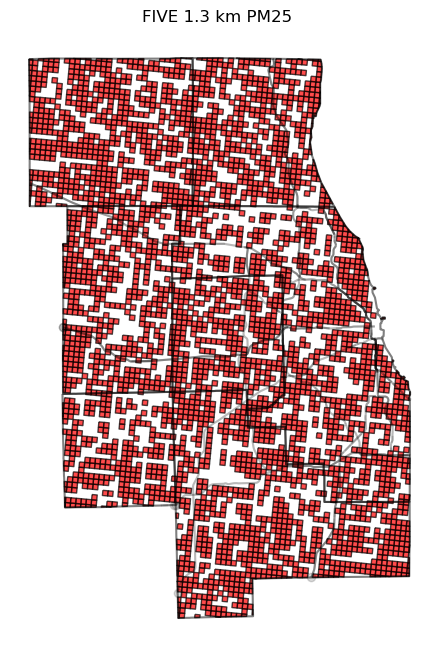

In [65]:
# Calculate the difference between PM25 and PM25_mean
cmap_five['PM25_difference'] = cmap_five['PM25'] - cmap_ladco['PM25_mean']

# Identify polygons where the difference is greater than 2 times the standard deviation
mask = np.abs(cmap_five['PM25_difference']) >= 1 * cmap_five['pm25_std_dev']
selected_polygons = cmap_five[mask]

# Plot the polygons
fig,ax = plt.subplots(figsize=((12,8)))
selected_polygons.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

# Set a finite and positive aspect ratio
#ax.set_aspect('equal')
ax.set_axis_off()
plt.title('FIVE 1.3 km PM25 ')
plt.show()


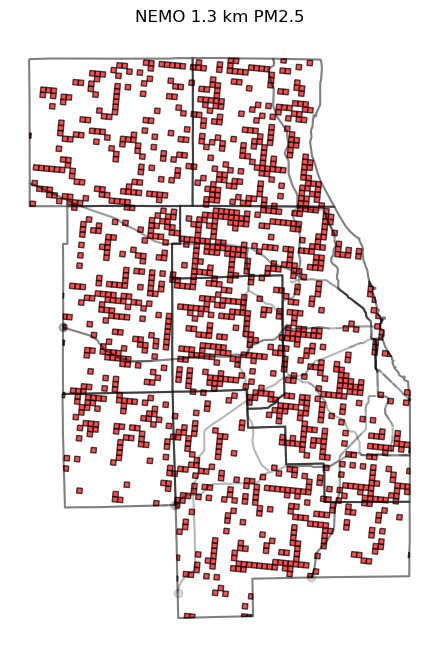

In [66]:
# Calculate the difference between PM25 and PM25_mean
cmap_nemo['PM25_difference'] = cmap_nemo['PM25'] - cmap_ladco['PM25_mean']

# Identify polygons where the difference is greater than 2 times the standard deviation
mask = np.abs(cmap_nemo['PM25_difference']) >= 1 * cmap_nemo['pm25_std_dev']
selected_polygons = cmap_nemo[mask]

# Plot the polygons
fig,ax = plt.subplots(figsize=((12,8)))

selected_polygons.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

# Set a finite and positive aspect ratio
#ax.set_aspect('equal')
ax.set_axis_off()
plt.title('NEMO 1.3 km PM2.5')
plt.show()

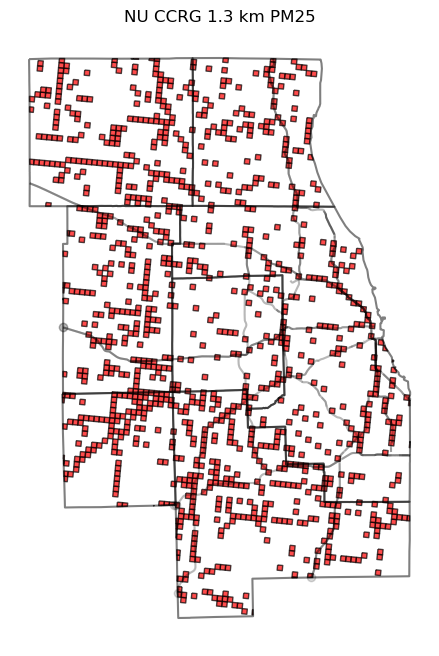

In [67]:
# Calculate the difference between PM25 and PM25_mean
cmap_ladco['PM25_difference'] = cmap_ladco['PM25'] - cmap_ladco['PM25_mean']

# Identify polygons where the difference is greater than 2 times the standard deviation
mask = np.abs(cmap_ladco['PM25_difference']) >= 1 * cmap_ladco['pm25_std_dev']
selected_polygons = cmap_ladco[mask]

# Plot the polygons
fig,ax = plt.subplots(figsize=((12,8)))
selected_polygons.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

# Set a finite and positive aspect ratio
#ax.set_aspect('equal')
ax.set_axis_off()
plt.title('NU CCRG 1.3 km PM25')
plt.show()

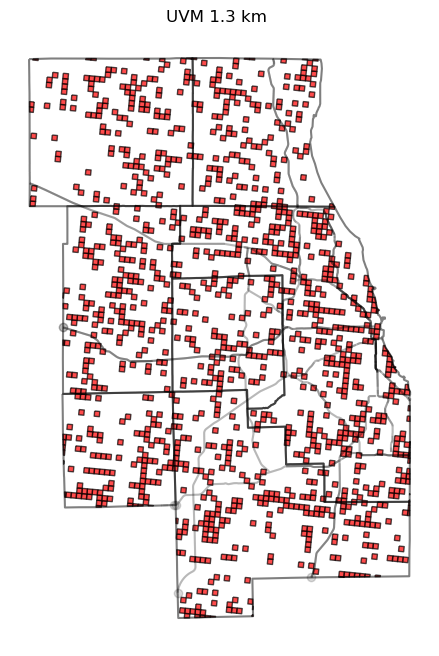

In [68]:
# Calculate the difference between PM25 and PM25_mean
cmap_rowan['PM25_difference'] = cmap_rowan['PM25'] - cmap_ladco['PM25_mean']

# Identify polygons where the difference is greater than 2 times the standard deviation
mask = np.abs(cmap_rowan['PM25_difference']) >= 1 * cmap_rowan['pm25_std_dev']
selected_polygons = cmap_rowan[mask]

# Plot the polygons
fig,ax = plt.subplots(figsize=((12,8)))
selected_polygons.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

cmap_cty.boundary.plot(ax=ax,color='k', alpha=.5)
cmap_roads.plot(ax=ax,color='k', alpha=.15)

# Set a finite and positive aspect ratio
#ax.set_aspect('equal')
ax.set_axis_off()
plt.title('UVM 1.3 km ')
plt.show()


<h1> NOx Histograms and Scatter plots

C:\Users\x12la\AppData\Local\Temp\ipykernel_11044\3988593634.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10e3)


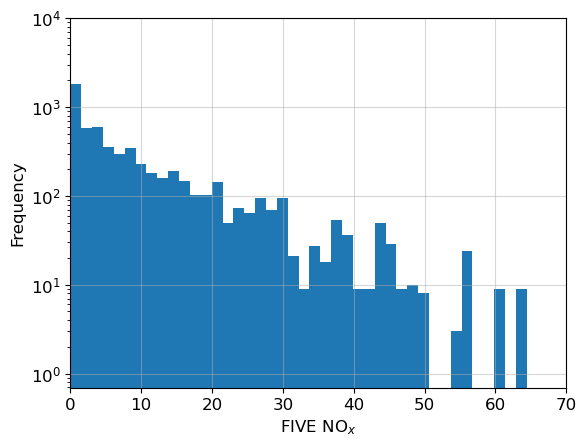

In [69]:
#Difference between NEMO & LADCO
cmap_five['NOX'].plot.hist(bins=50, log=True)
plt.xlabel('FIVE NO$_x$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0,70)
plt.ylim(0,10e3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=.5)

C:\Users\x12la\AppData\Local\Temp\ipykernel_11044\2894381984.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10e3)


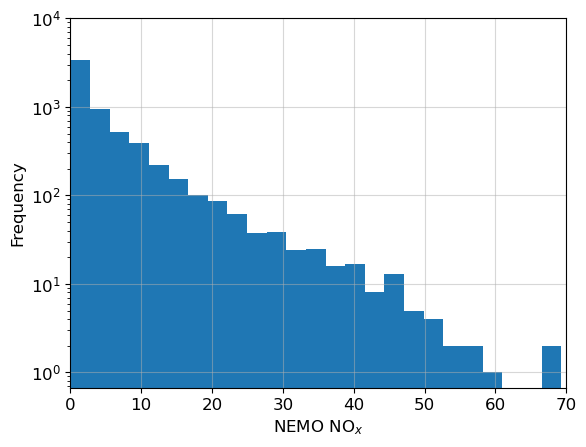

In [70]:
#Difference between NEMO & LADCO
cmap_nemo['NOX'].plot.hist(bins=50, log=True)
plt.xlabel('NEMO NO$_x$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0,70)
plt.ylim(0,10e3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=.5)

C:\Users\x12la\AppData\Local\Temp\ipykernel_11044\4080736699.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10e3)


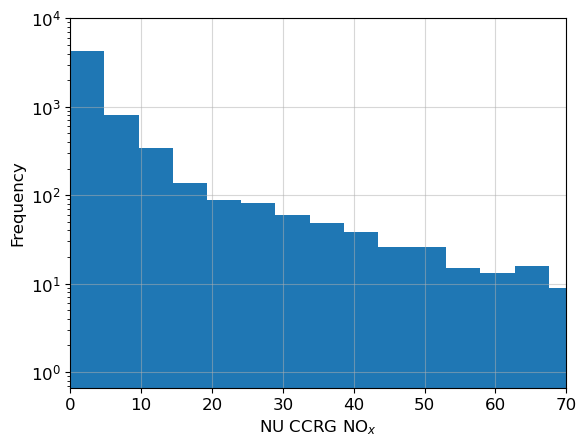

In [71]:
#plt.figure(figsize=(10,10))
cmap_ladco['NOX'].plot.hist(bins=50, log=True)
plt.xlabel('NU CCRG NO$_x$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0,70)
plt.ylim(0,10e3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=.5)

C:\Users\x12la\AppData\Local\Temp\ipykernel_11044\3346898393.py:6: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10e3)


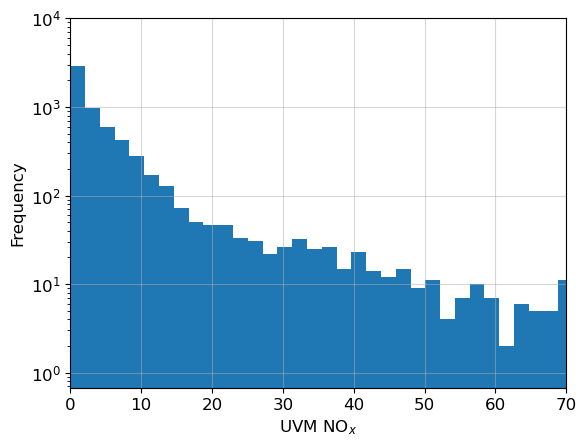

In [72]:
#Difference between NEMO & LADCO
cmap_rowan['NOX'].plot.hist(bins=50, log=True)
plt.xlabel('UVM NO$_x$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0,70)
plt.ylim(0,10e3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=.5)

4.40804


(0.0, 70.0)

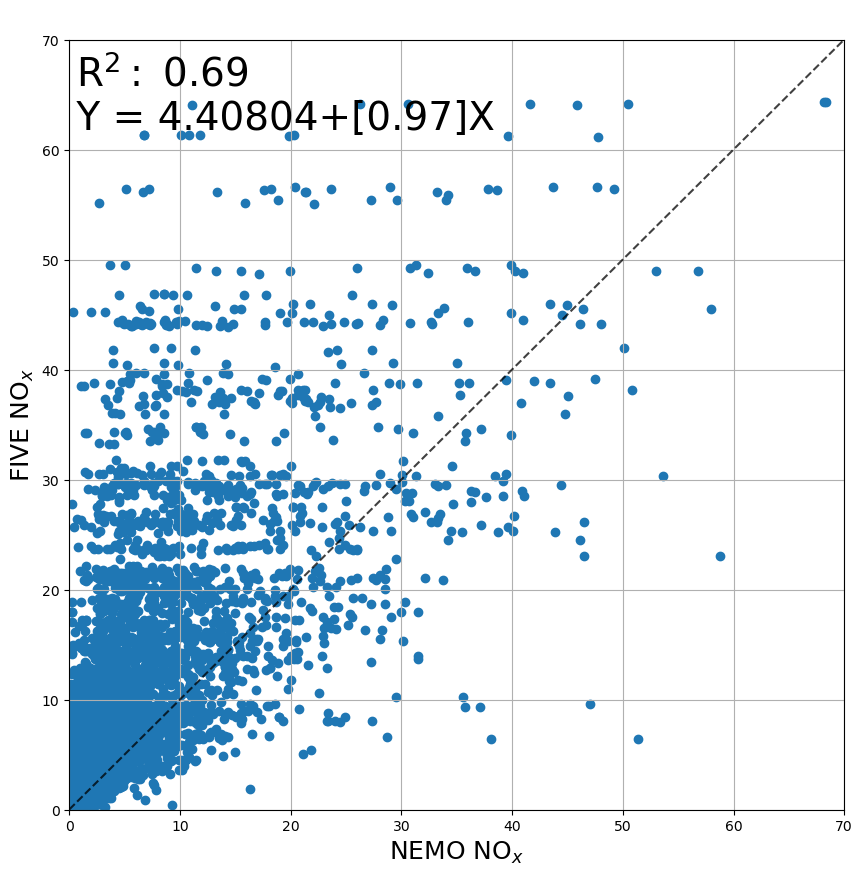

In [73]:
#from sklearn.linear_model import LinearRegressio
y = np.array(cmap_five['NOX'])
x = np.array(cmap_nemo['NOX'])

bias = x - y
meanbias = np.sum(bias)/(len(bias))
rmsd = np.sqrt(((bias)**2).mean())

model = LinearRegression().fit(np.reshape(x,(-1,1)), y)
r_sq = model.score(np.reshape(x,(-1,1)), y)
print(str(np.around(model.intercept_,5)))
mu_d,mu_p,nmb,nme,r,p = stats_normalized(x,y)

# Bias scatter plot, include linear regression fit line (red, solid) and perfect linear regresion fit (black dashed)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot([y.min(),70], [y.min(),70], c='black', linestyle="--", alpha=0.75) #linear plot
#plt.plot(np.reshape(x,(-1,1)) , model.predict(np.reshape(x,(-1,1))), color='r')
plt.grid()
# print out statistics on graph 
plt.gcf().text(.12,.79, 
                #"\n NMB: " +  str(np.around(nmb,4)) +
                #"\n NME: " +  str(np.around(nme,4)) +
                "\n R$^2:$ " +  str(np.around(r,2)) +
                "\n Y = " + str(np.around(model.intercept_,5)) + "+" + str(np.around(model.coef_,2)) +"X",
               #"\n p: " +  str(np.around(p,5)),
        fontsize=28)
plt.xlabel("NEMO NO$_x$", fontsize=18)
plt.ylabel("FIVE NO$_x$", fontsize=18)
plt.xlim(0,70)
plt.ylim(0,70)

(0.0, 70.0)

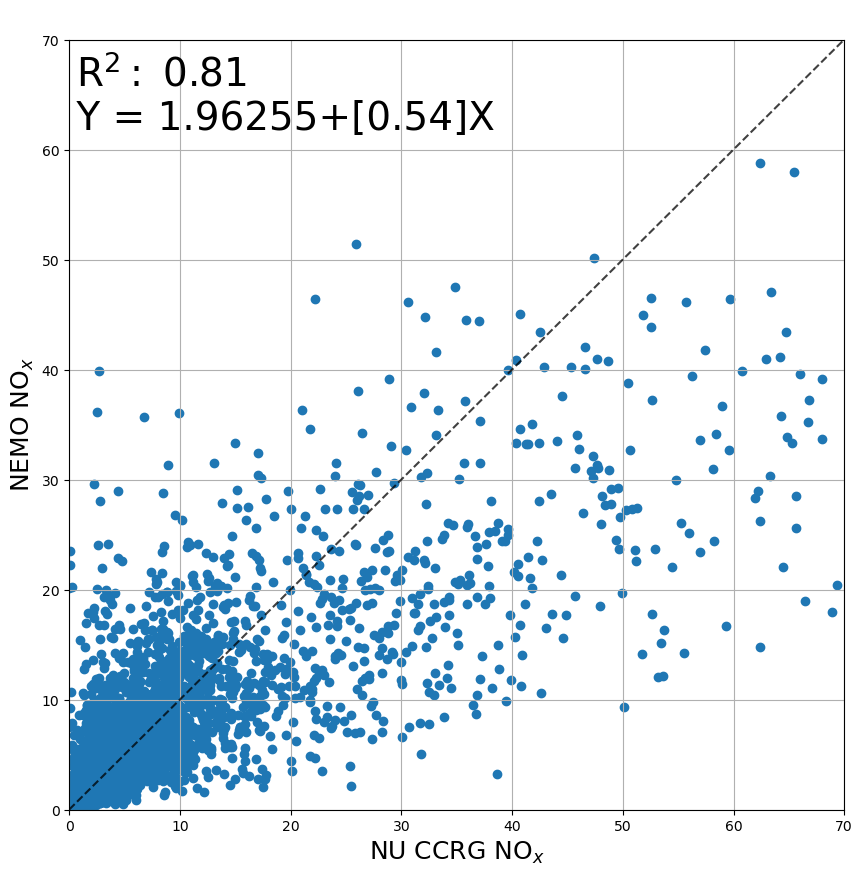

In [74]:
#from sklearn.linear_model import LinearRegressio
x = np.array(cmap_ladco['NOX'])
y = np.array(cmap_nemo['NOX'])

bias = x - y
meanbias = np.sum(bias)/(len(bias))

model = LinearRegression().fit(np.reshape(x,(-1,1)), y)
r_sq = model.score(np.reshape(x,(-1,1)), y)

mu_d,mu_p,nmb,nme,r,p = stats_normalized(x,y)

# Bias scatter plot, include linear regression fit line (red, solid) and perfect linear regresion fit (black dashed)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot([y.min(),70], [y.min(),70], c='black', linestyle="--", alpha=0.75) #linear plot
#plt.plot(np.reshape(x,(-1,1)) , model.predict(np.reshape(x,(-1,1))), color='r')
plt.grid()
# print out statistics on graph 
plt.gcf().text(.12,.79, 
                #"\n NMB: " +  str(np.around(nmb,4)) +
                #"\n NME: " +  str(np.around(nme,4)) +
                "\n R$^2:$ " +  str(np.around(r,2)) +
                "\n Y = " + str(np.around(model.intercept_,5)) + "+" + str(np.around(model.coef_,2)) +"X",
               #"\n p: " +  str(np.around(p,5)),
        fontsize=28)
plt.ylabel("NEMO NO$_x$", fontsize=18)
plt.xlabel("NU CCRG NO$_x$", fontsize=18)
plt.xlim(0,70)
plt.ylim(0,70)

(0.0, 70.0)

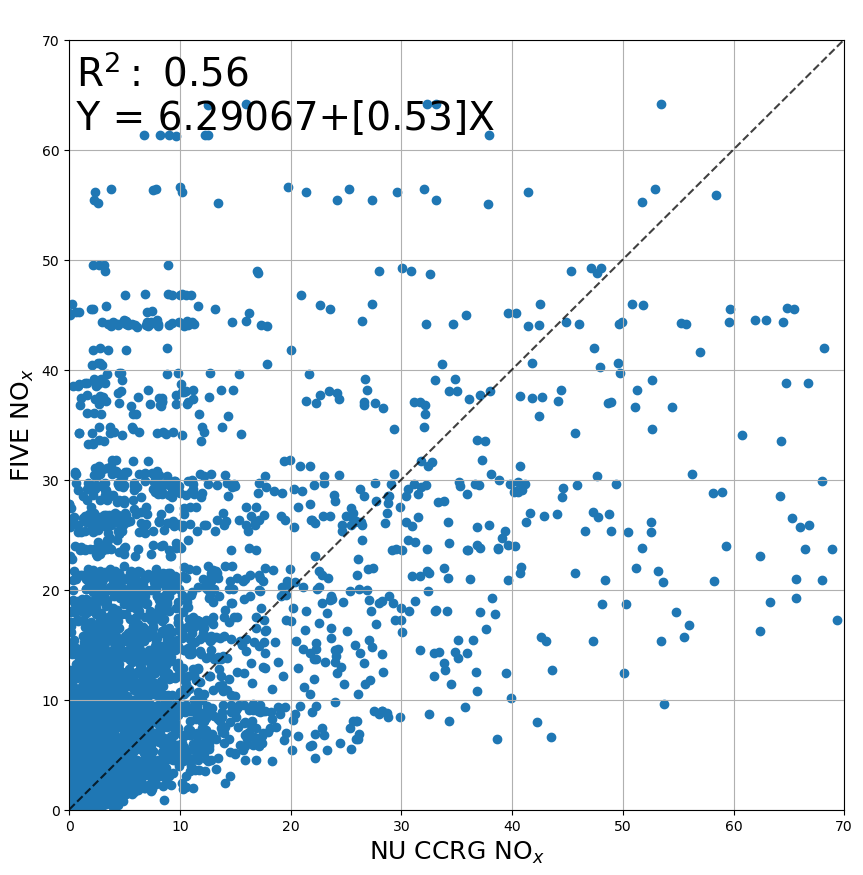

In [75]:
#from sklearn.linear_model import LinearRegressio
x = np.array(cmap_ladco['NOX'])
y = np.array(cmap_five['NOX'])

bias = x - y
meanbias = np.sum(bias)/(len(bias))

model = LinearRegression().fit(np.reshape(x,(-1,1)), y)
r_sq = model.score(np.reshape(x,(-1,1)), y)
mu_d,mu_p,nmb,nme,r,p = stats_normalized(x,y)

# Bias scatter plot, include linear regression fit line (red, solid) and perfect linear regresion fit (black dashed)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot([y.min(),70], [y.min(),70], c='black', linestyle="--", alpha=0.75) #linear plot
#plt.plot(np.reshape(x,(-1,1)) , model.predict(np.reshape(x,(-1,1))), color='r')
plt.grid()
# print out statistics on graph 
plt.gcf().text(.12,.79, 
                #"\n NMB: " +  str(np.around(nmb,4)) +
                #"\n NME: " +  str(np.around(nme,4)) +
                "\n R$^2:$ " +  str(np.around(r,2)) +
                "\n Y = " + str(np.around(model.intercept_,5)) + "+" + str(np.around(model.coef_,2)) +"X",
               #"\n p: " +  str(np.around(p,5)),
        fontsize=28)
plt.ylabel("FIVE NO$_x$", fontsize=18)
plt.xlabel("NU CCRG NO$_x$", fontsize=18)
plt.xlim(0,70)
plt.ylim(0,70)

(0.0, 70.0)

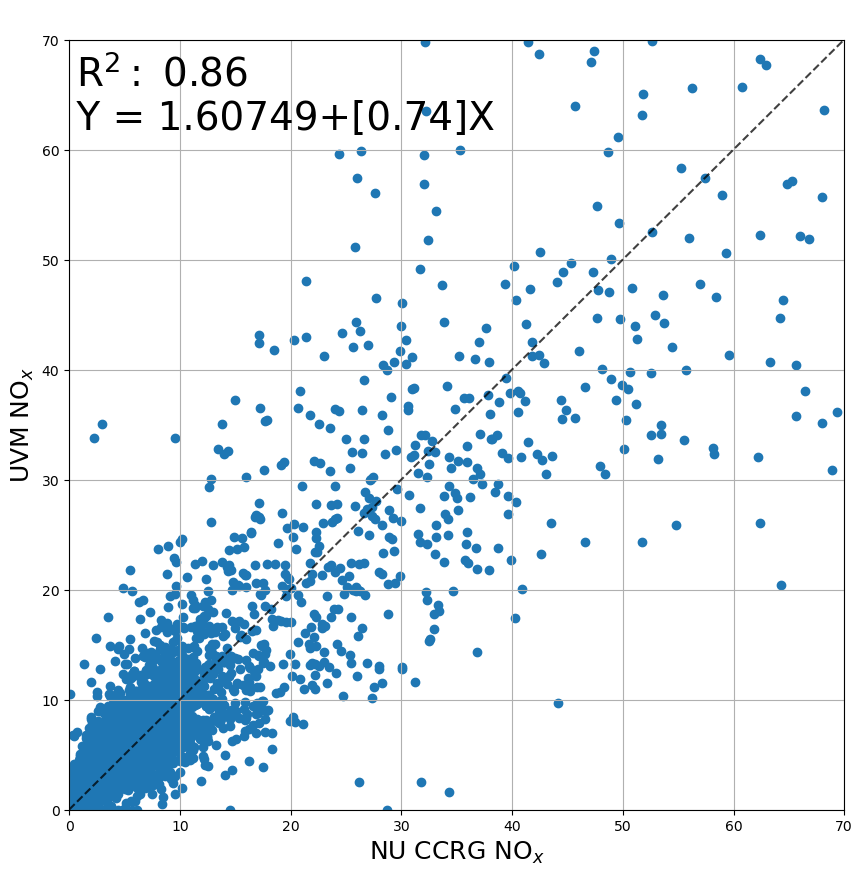

In [76]:
#from sklearn.linear_model import LinearRegressio
x = np.array(cmap_ladco['NOX'])
y = np.array(cmap_rowan['NOX'] )

bias = x - y
meanbias = np.sum(bias)/(len(bias))

model = LinearRegression().fit(np.reshape(x,(-1,1)), y)
r_sq = model.score(np.reshape(x,(-1,1)), y)
mu_d,mu_p,nmb,nme,r,p = stats_normalized(x,y)

# Bias scatter plot, include linear regression fit line (red, solid) and perfect linear regresion fit (black dashed)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot([y.min(),70], [y.min(),70], c='black', linestyle="--", alpha=0.75) #linear plot
#plt.plot(np.reshape(x,(-1,1)) , model.predict(np.reshape(x,(-1,1))), color='r')
plt.grid()
# print out statistics on graph 
plt.gcf().text(.12,.79, 
                #"\n NMB: " +  str(np.around(nmb,4)) +
                #"\n NME: " +  str(np.around(nme,4)) +
                "\n R$^2:$ " +  str(np.around(r,2)) +
                "\n Y = " + str(np.around(model.intercept_,5)) + "+" + str(np.around(model.coef_,2)) +"X",
               #"\n p: " +  str(np.around(p,5)),
        fontsize=28)
plt.ylabel("UVM NO$_x$", fontsize=18)
plt.xlabel("NU CCRG NO$_x$", fontsize=18)
plt.xlim(0,70)
plt.ylim(0,70)

(0.0, 70.0)

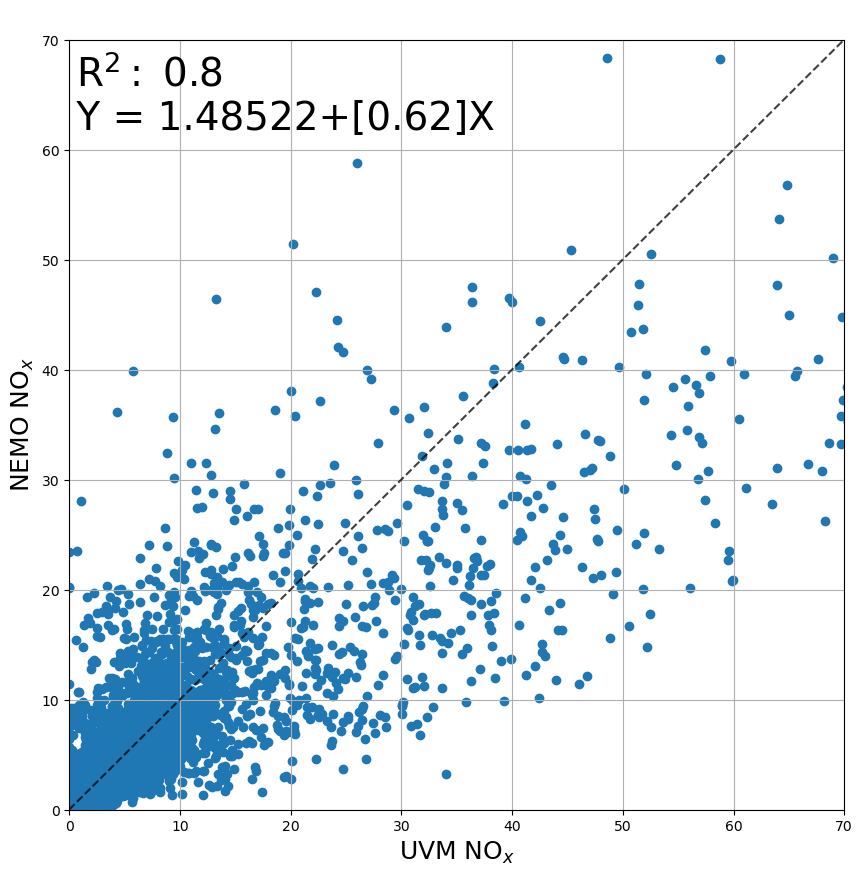

In [77]:
#from sklearn.linear_model import LinearRegressio
y= np.array(cmap_nemo['NOX'])
x = np.array(cmap_rowan['NOX'] )

bias = x - y
meanbias = np.sum(bias)/(len(bias))

model = LinearRegression().fit(np.reshape(x,(-1,1)), y)
r_sq = model.score(np.reshape(x,(-1,1)), y)
mu_d,mu_p,nmb,nme,r,p = stats_normalized(x,y)

# Bias scatter plot, include linear regression fit line (red, solid) and perfect linear regresion fit (black dashed)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot([y.min(),70], [y.min(),70], c='black', linestyle="--", alpha=0.75) #linear plot
#plt.plot(np.reshape(x,(-1,1)) , model.predict(np.reshape(x,(-1,1))), color='r')
plt.grid()
# print out statistics on graph 
plt.gcf().text(.12,.79, 
                #"\n NMB: " +  str(np.around(nmb,4)) +
                #"\n NME: " +  str(np.around(nme,4)) +
                "\n R$^2:$ " +  str(np.around(r,2)) +
                "\n Y = " + str(np.around(model.intercept_,5)) + "+" + str(np.around(model.coef_,2)) +"X",
               #"\n p: " +  str(np.around(p,5)),
        fontsize=28)
plt.xlabel("UVM NO$_x$", fontsize=18)
plt.ylabel("NEMO NO$_x$", fontsize=18)
plt.xlim(0,70)
plt.ylim(0,70)

(0.0, 70.0)

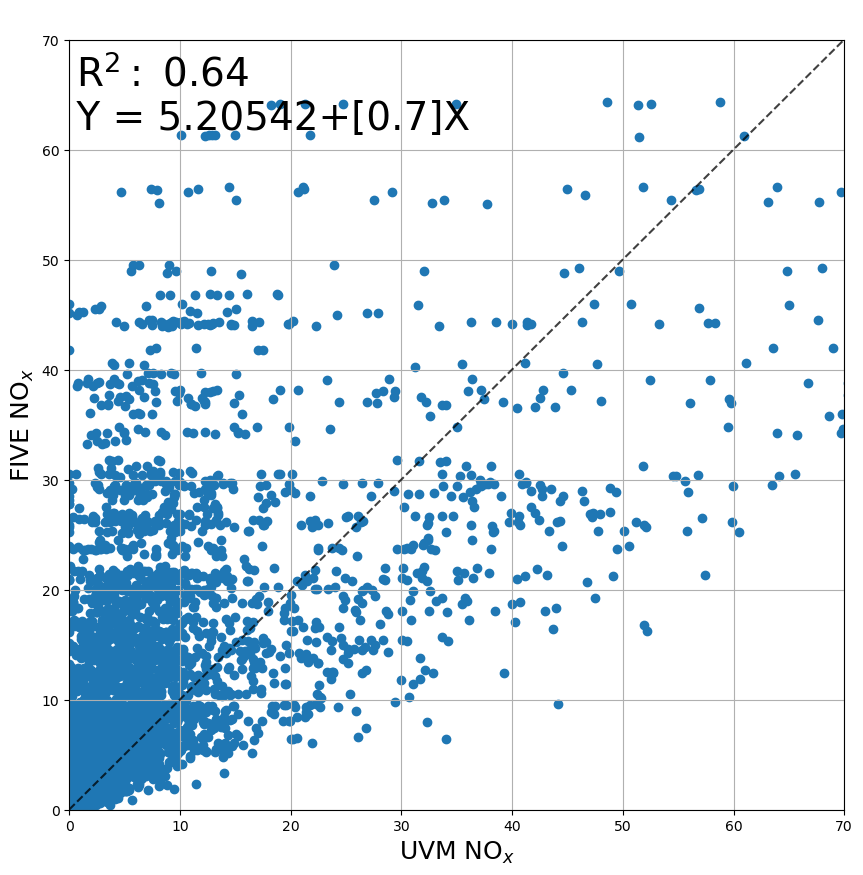

In [78]:
#from sklearn.linear_model import LinearRegressio
x = np.array(cmap_rowan['NOX'])
y = np.array(cmap_five['NOX'])

bias = x - y
meanbias = np.sum(bias)/(len(bias))

model = LinearRegression().fit(np.reshape(x,(-1,1)), y)
r_sq = model.score(np.reshape(x,(-1,1)), y)
mu_d,mu_p,nmb,nme,r,p = stats_normalized(x,y)

# Bias scatter plot, include linear regression fit line (red, solid) and perfect linear regresion fit (black dashed)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot([y.min(),70], [y.min(),70], c='black', linestyle="--", alpha=0.75) #linear plot
#plt.plot(np.reshape(x,(-1,1)) , model.predict(np.reshape(x,(-1,1))), color='r')
plt.grid()
# print out statistics on graph 
plt.gcf().text(.12,.79, 
                #"\n NMB: " +  str(np.around(nmb,4)) +
                #"\n NME: " +  str(np.around(nme,4)) +
                "\n R$^2:$ " +  str(np.around(r,2)) +
                "\n Y = " + str(np.around(model.intercept_,5)) + "+" + str(np.around(model.coef_,2)) +"X",
               #"\n p: " +  str(np.around(p,5)),
        fontsize=28)
plt.ylabel("FIVE NO$_x$", fontsize=18)
plt.xlabel("UVM NO$_x$", fontsize=18)
plt.xlim(0,70)
plt.ylim(0,70)

<h1> PM25 Histograms and Scatter plots

In [79]:
#Difference between NEMO & LADCO
cmap_five['PM25'].plot.hist(bins=50, log=True)
#plt.title("Annual Average PM25", fontsize=16)
plt.xlabel('FIVE PM$_2$$_.$$_5$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0,5)
plt.ylim(0,10e3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=.5)

C:\Users\x12la\AppData\Local\Temp\ipykernel_11044\1120819267.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10e3)


In [80]:
#Difference between NEMO & LADCO
cmap_nemo['PM25'].plot.hist(bins=50, log=True)
#plt.title("Annual Average PM25", fontsize=16)
plt.xlabel('NEMO PM$_2$$_.$$_5$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0,5)
plt.ylim(0,10e3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=.5)

C:\Users\x12la\AppData\Local\Temp\ipykernel_11044\2768703858.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10e3)


C:\Users\x12la\AppData\Local\Temp\ipykernel_11044\2215808674.py:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10e3)


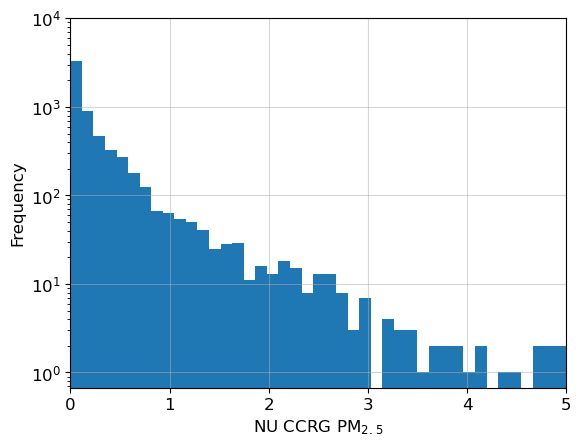

In [81]:
#Difference between NEMO & LADCO
#plt.figure(figsize=(10,10))
cmap_ladco['PM25'].plot.hist(bins=100, log=True)
#plt.title("Annual Average PM25", fontsize=16)
plt.xlabel('NU CCRG PM$_2$$_.$$_5$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0,5)
plt.ylim(0,10e3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=.5)

C:\Users\x12la\AppData\Local\Temp\ipykernel_11044\680658132.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10e3)


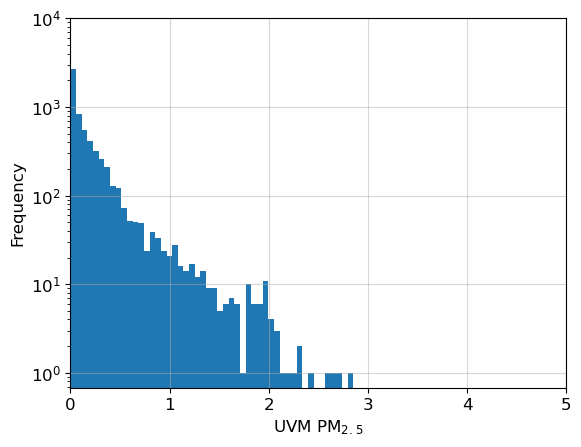

In [82]:
#Difference between NEMO & LADCO
cmap_rowan['PM25'].plot.hist(bins=50, log=True)
#plt.title("Annual Average PM25", fontsize=16)
plt.xlabel('UVM PM$_2$$_.$$_5$', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0,5)
plt.ylim(0,10e3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=.5)

In [83]:
#from sklearn.linear_model import LinearRegressio
y = np.array(cmap_five['PM25'])
x = np.array(cmap_nemo['PM25'])

bias = x - y
meanbias = np.sum(bias)/(len(bias))

model = LinearRegression().fit(np.reshape(x,(-1,1)), y)
r_sq = model.score(np.reshape(x,(-1,1)), y)

mu_d,mu_p,nmb,nme,r,p = stats_normalized(x,y)

# Bias scatter plot, include linear regression fit line (red, solid) and perfect linear regresion fit (black dashed)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot([x.min(),5], [x.min(),5], c='black', linestyle="--", alpha=0.75) #linear plot
#plt.plot(np.reshape(x,(-1,1)) , model.predict(np.reshape(x,(-1,1))), color='r')
plt.grid()
# print out statistics on graph 
plt.gcf().text(.12,.79, 
                #"\n NMB: " +  str(np.around(nmb,4)) +
                #"\n NME: " +  str(np.around(nme,4)) +
                "\n R$^2:$ " +  str(np.around(r,2)) +
                "\n Y = " + str(np.around(model.intercept_,5)) + "+" + str(np.around(model.coef_,2)) +"X",
               #"\n p: " +  str(np.around(p,5)),
        fontsize=28)
plt.xlabel("NEMO PM$_2$$_.$$_5$", fontsize=18)
plt.ylabel("FIVE PM$_2$$_.$$_5$", fontsize=18)
plt.xlim(0,5)
plt.ylim(0,5)
#plt.title("FIVE v NEMO On-road PM25 Emission", fontsize=20)

(0.0, 5.0)

(0.0, 5.0)

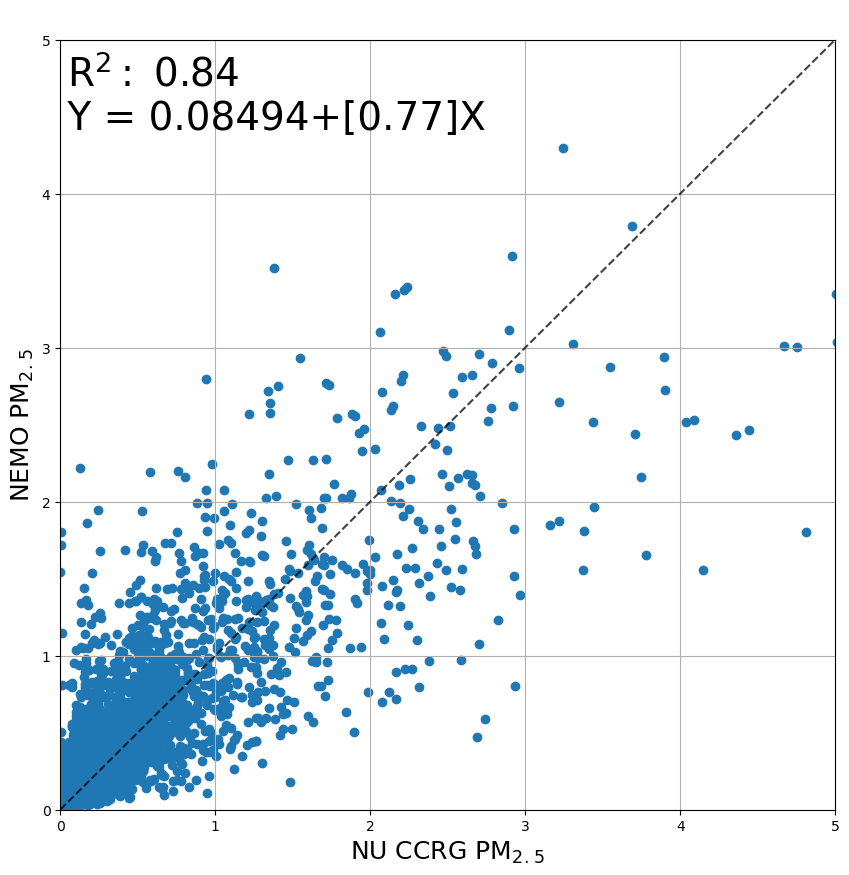

In [84]:
#from sklearn.linear_model import LinearRegressio
x = np.array(cmap_ladco['PM25'])
y = np.array(cmap_nemo['PM25'])

bias = x - y
meanbias = np.sum(bias)/(len(bias))

model = LinearRegression().fit(np.reshape(x,(-1,1)), y)
r_sq = model.score(np.reshape(x,(-1,1)), y)

mu_d,mu_p,nmb,nme,r,p = stats_normalized(x,y)

# Bias scatter plot, include linear regression fit line (red, solid) and perfect linear regresion fit (black dashed)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot([x.min(),5], [x.min(),5], c='black', linestyle="--", alpha=0.75) #linear plot
#plt.plot(np.reshape(x,(-1,1)) , model.predict(np.reshape(x,(-1,1))), color='r')
plt.grid()
# print out statistics on graph 
plt.gcf().text(.12,.79, 
                #"\n NMB: " +  str(np.around(nmb,4)) +
                #"\n NME: " +  str(np.around(nme,4)) +
                "\n R$^2:$ " +  str(np.around(r,2)) +
                "\n Y = " + str(np.around(model.intercept_,5)) + "+" + str(np.around(model.coef_,2)) +"X",
               #"\n p: " +  str(np.around(p,5)),
        fontsize=28)
plt.ylabel("NEMO PM$_2$$_.$$_5$", fontsize=18)
plt.xlabel("NU CCRG PM$_2$$_.$$_5$", fontsize=18)
plt.xlim(0,5)
plt.ylim(0,5)
#plt.title("LADCO v NEMO On-road PM25 Emission", fontsize=20)

(0.0, 5.0)

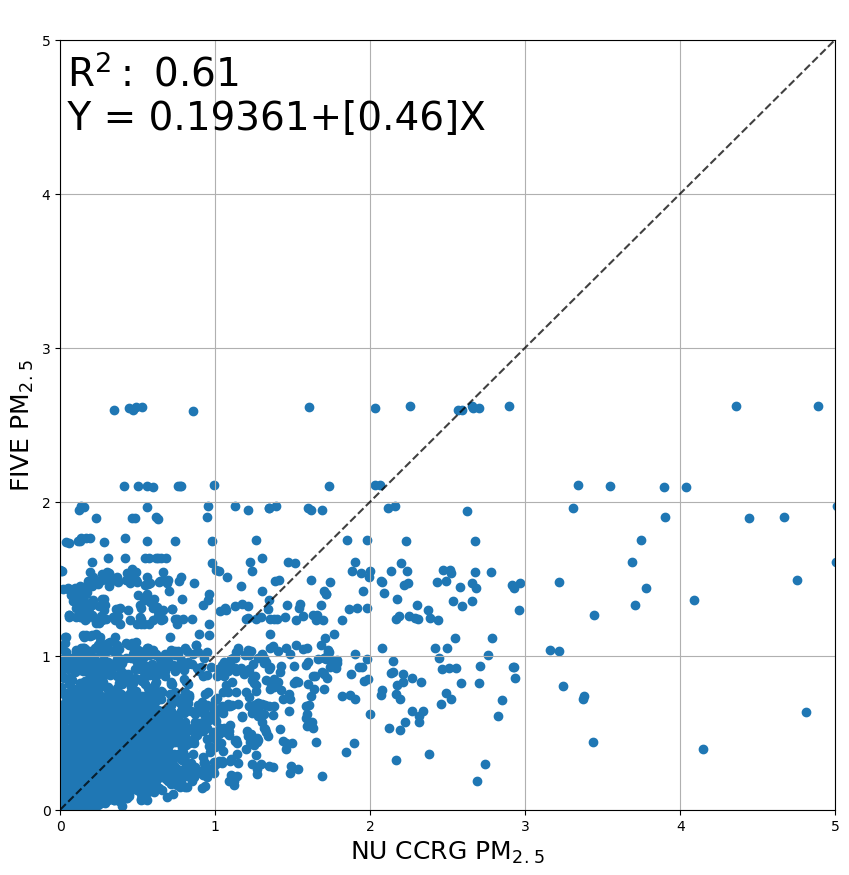

In [85]:
#from sklearn.linear_model import LinearRegressio
x = np.array(cmap_ladco['PM25'])
y = np.array(cmap_five['PM25'])

bias = x - y
meanbias = np.sum(bias)/(len(bias))

model = LinearRegression().fit(np.reshape(x,(-1,1)), y)
r_sq = model.score(np.reshape(x,(-1,1)), y)
mu_d,mu_p,nmb,nme,r,p = stats_normalized(x,y)

# Bias scatter plot, include linear regression fit line (red, solid) and perfect linear regresion fit (black dashed)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot([x.min(),5], [x.min(),5], c='black', linestyle="--", alpha=0.75) #linear plot
#plt.plot(np.reshape(x,(-1,1)) , model.predict(np.reshape(x,(-1,1))), color='r')
plt.grid()
# print out statistics on graph 
plt.gcf().text(.12,.79, 
                #"\n NMB: " +  str(np.around(nmb,4)) +
                #"\n NME: " +  str(np.around(nme,4)) +
                "\n R$^2:$ " +  str(np.around(r,2)) +
                "\n Y = " + str(np.around(model.intercept_,5)) + "+" + str(np.around(model.coef_,2)) +"X",
               #"\n p: " +  str(np.around(p,5)),
        fontsize=28)
plt.ylabel("FIVE PM$_2$$_.$$_5$", fontsize=18)
plt.xlabel("NU CCRG PM$_2$$_.$$_5$", fontsize=18)
plt.xlim(0,5)
plt.ylim(0,5)
#plt.title("LADCO v FIVE On-road PM25 Emission", fontsize=20)

(0.0, 5.0)

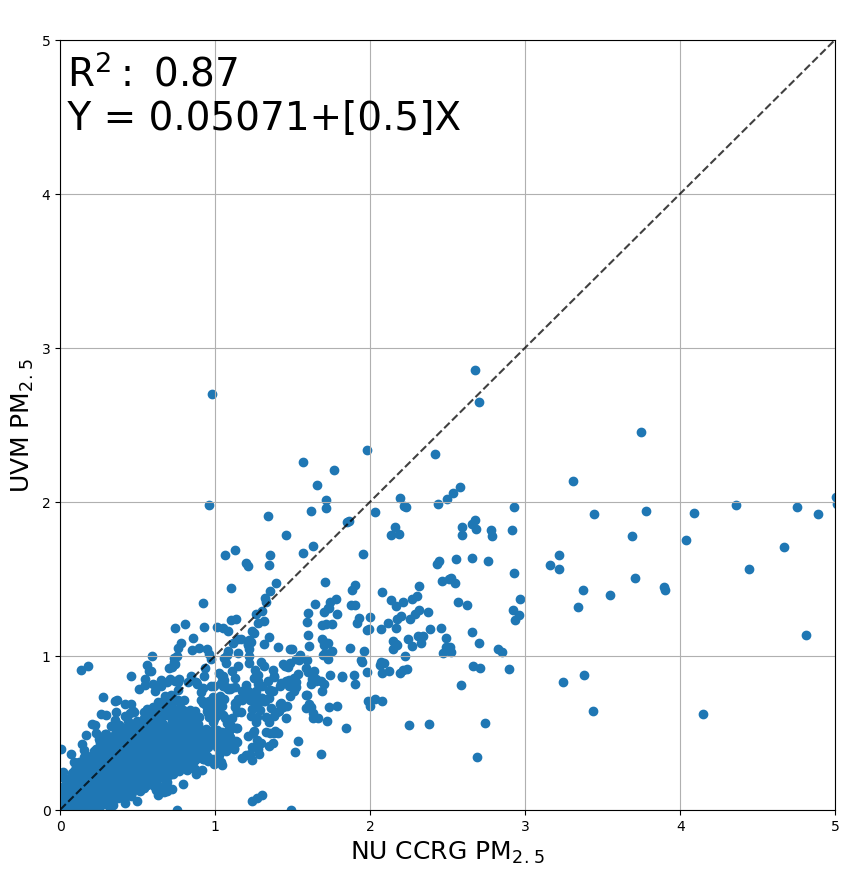

In [86]:
#from sklearn.linear_model import LinearRegressio
x = np.array(cmap_ladco['PM25'])
y = np.array(cmap_rowan['PM25'] )

bias = x - y
meanbias = np.sum(bias)/(len(bias))

model = LinearRegression().fit(np.reshape(x,(-1,1)), y)
r_sq = model.score(np.reshape(x,(-1,1)), y)
mu_d,mu_p,nmb,nme,r,p = stats_normalized(x,y)

# Bias scatter plot, include linear regression fit line (red, solid) and perfect linear regresion fit (black dashed)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot([x.min(),5], [x.min(),5], c='black', linestyle="--", alpha=0.75) #linear plot
#plt.plot(np.reshape(x,(-1,1)) , model.predict(np.reshape(x,(-1,1))), color='r')
plt.grid()
# print out statistics on graph 
plt.gcf().text(.12,.79, 
                #"\n NMB: " +  str(np.around(nmb,4)) +
                #"\n NME: " +  str(np.around(nme,4)) +
                "\n R$^2:$ " +  str(np.around(r,2)) +
                "\n Y = " + str(np.around(model.intercept_,5)) + "+" + str(np.around(model.coef_,2)) +"X",
               #"\n p: " +  str(np.around(p,5)),
        fontsize=28)
plt.ylabel("UVM PM$_2$$_.$$_5$", fontsize=18)
plt.xlabel("NU CCRG PM$_2$$_.$$_5$", fontsize=18)
plt.xlim(0,5)
plt.ylim(0,5)
#plt.title("LADCO v Rowangould On-road PM25 Emission", fontsize=20)

(0.0, 5.0)

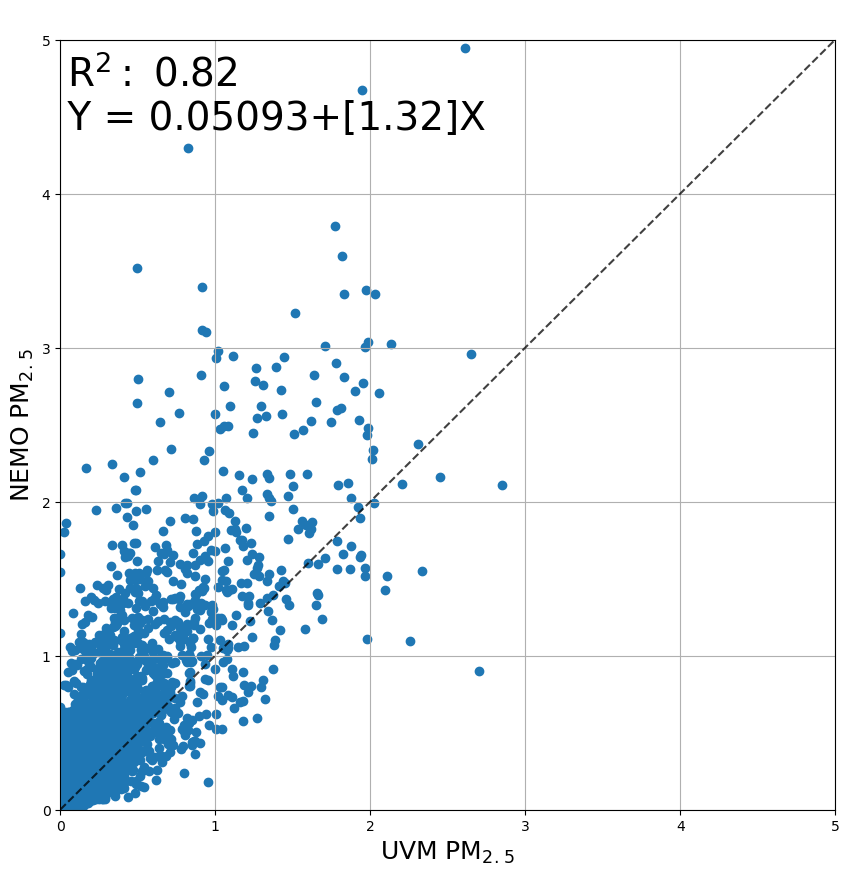

In [87]:
#from sklearn.linear_model import LinearRegressio
y= np.array(cmap_nemo['PM25'])
x = np.array(cmap_rowan['PM25'] )

bias = x - y
meanbias = np.sum(bias)/(len(bias))

model = LinearRegression().fit(np.reshape(x,(-1,1)), y)
r_sq = model.score(np.reshape(x,(-1,1)), y)
mu_d,mu_p,nmb,nme,r,p = stats_normalized(x,y)

# Bias scatter plot, include linear regression fit line (red, solid) and perfect linear regresion fit (black dashed)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot([x.min(),5], [x.min(),5], c='black', linestyle="--", alpha=0.75) #linear plot
#plt.plot(np.reshape(x,(-1,1)) , model.predict(np.reshape(x,(-1,1))), color='r')
plt.grid()
# print out statistics on graph 
plt.gcf().text(.12,.79, 
                #"\n NMB: " +  str(np.around(nmb,4)) +
                #"\n NME: " +  str(np.around(nme,4)) +
                "\n R$^2:$ " +  str(np.around(r,2)) +
                "\n Y = " + str(np.around(model.intercept_,5)) + "+" + str(np.around(model.coef_,2)) +"X",
               #"\n p: " +  str(np.around(p,5)),
        fontsize=28)
plt.xlabel("UVM PM$_2$$_.$$_5$", fontsize=18)
plt.ylabel("NEMO PM$_2$$_.$$_5$", fontsize=18)
plt.xlim(0,5)
plt.ylim(0,5)
#plt.title("NEMO v Rowangould On-road PM25 Emission", fontsize=20)

(0.0, 5.0)

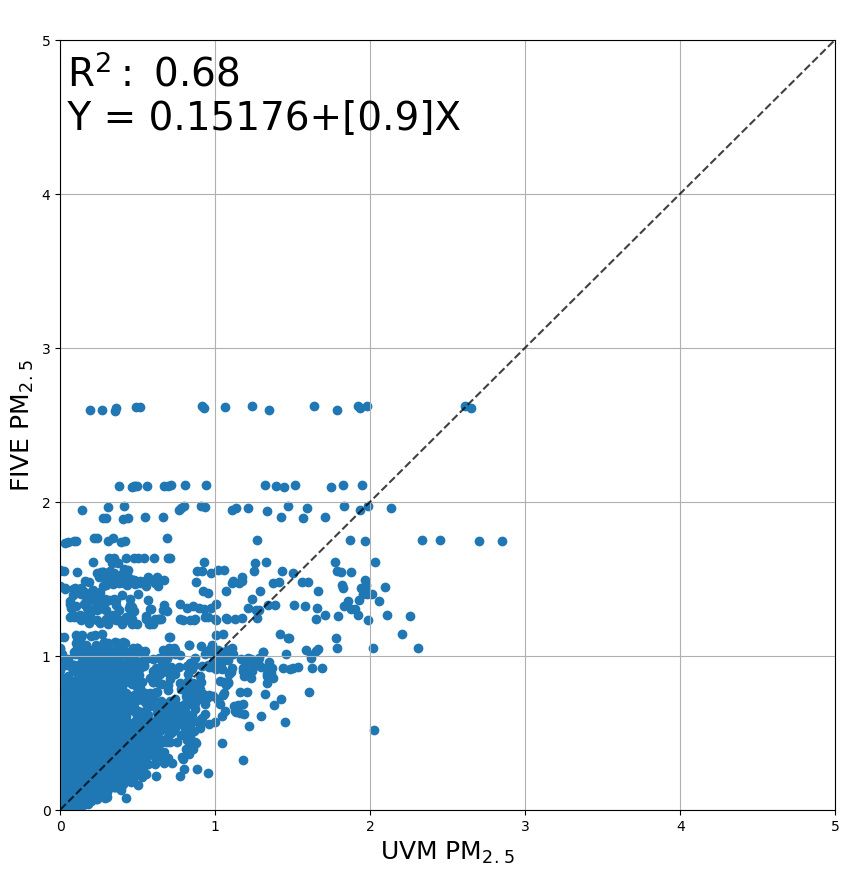

In [88]:
#from sklearn.linear_model import LinearRegressio
x = np.array(cmap_rowan['PM25'])
y = np.array(cmap_five['PM25'])

bias = x - y
meanbias = np.sum(bias)/(len(bias))

model = LinearRegression().fit(np.reshape(x,(-1,1)), y)
r_sq = model.score(np.reshape(x,(-1,1)), y)
mu_d,mu_p,nmb,nme,r,p = stats_normalized(x,y)

# Bias scatter plot, include linear regression fit line (red, solid) and perfect linear regresion fit (black dashed)
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.plot([x.min(),5], [x.min(),5], c='black', linestyle="--", alpha=0.75) #linear plot
#plt.plot(np.reshape(x,(-1,1)) , model.predict(np.reshape(x,(-1,1))), color='r')
plt.grid()
# print out statistics on graph 
plt.gcf().text(.12,.79, 
                #"\n NMB: " +  str(np.around(nmb,4)) +
                #"\n NME: " +  str(np.around(nme,4)) +
                "\n R$^2:$ " +  str(np.around(r,2)) +
                "\n Y = " + str(np.around(model.intercept_,5)) + "+" + str(np.around(model.coef_,2)) +"X",
               #"\n p: " +  str(np.around(p,5)),
        fontsize=28)
plt.ylabel("FIVE PM$_2$$_.$$_5$", fontsize=18)
plt.xlabel("UVM PM$_2$$_.$$_5$", fontsize=18)
plt.xlim(0,5)
plt.ylim(0,5)
#plt.title("FIVE v Rowangould On-road PM25 Emission", fontsize=20)